# Clustering to Help Identify Probable Macrophage

### 1. Import Required Packages 
### 2. Import Prior Data 
### 3. Subset Data to Include Predominantly Macrophage Cells
### 4. Determine Top 2000 Variable Genes in Predominantly Macrophage Cells
### 5. Integration Cells with scVI <br>  5.1 Calculate neighbors and Conduct Leiden Clustering on 2000 highly variable gene adata <br> 5.2 Calculate neighbors and Conduct Leiden Clustering on ALL GENES adata 
### 6. Differential Gene Expression Analysis to Determine Unknown Clusters
### 7. Determine the Celltype of Each Cluster <br> KCs <br> MDMs <br> Neutrophils 

## <br> 1. Import Required Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import anndata as ad

from scvi.model.utils import mde
from scipy import sparse
from anndata import AnnData
from anndata.experimental.multi_files import AnnCollection

[rank: 0] Global seed set to 0


Set figure parameters.

In [2]:
sc.set_figure_params(figsize=(10, 8))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
pd.options.display.max_colwidth = 200

## <br> 2. Import Prior Clustered Data

In [8]:
adata = ad.read_h5ad('./Adata_Objects/01b_AllGenes_Clustered.h5ad')

In [9]:
adata.raw

In [10]:
print(adata)

AnnData object with n_obs × n_vars = 263074 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25', 'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50'
    uns: 'OrigIdent_colors', 'doublet_info_colors', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p_counts'
    obsp: 'connectivities', 'distances'


## <br> 3. Subset Predominantly Macrophage Cells

Based on previous clustering analysis and data transfer from original TC analysis using Seurat, the immune cells in the various clusters have been vaguely identified and subset using the following code. 

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


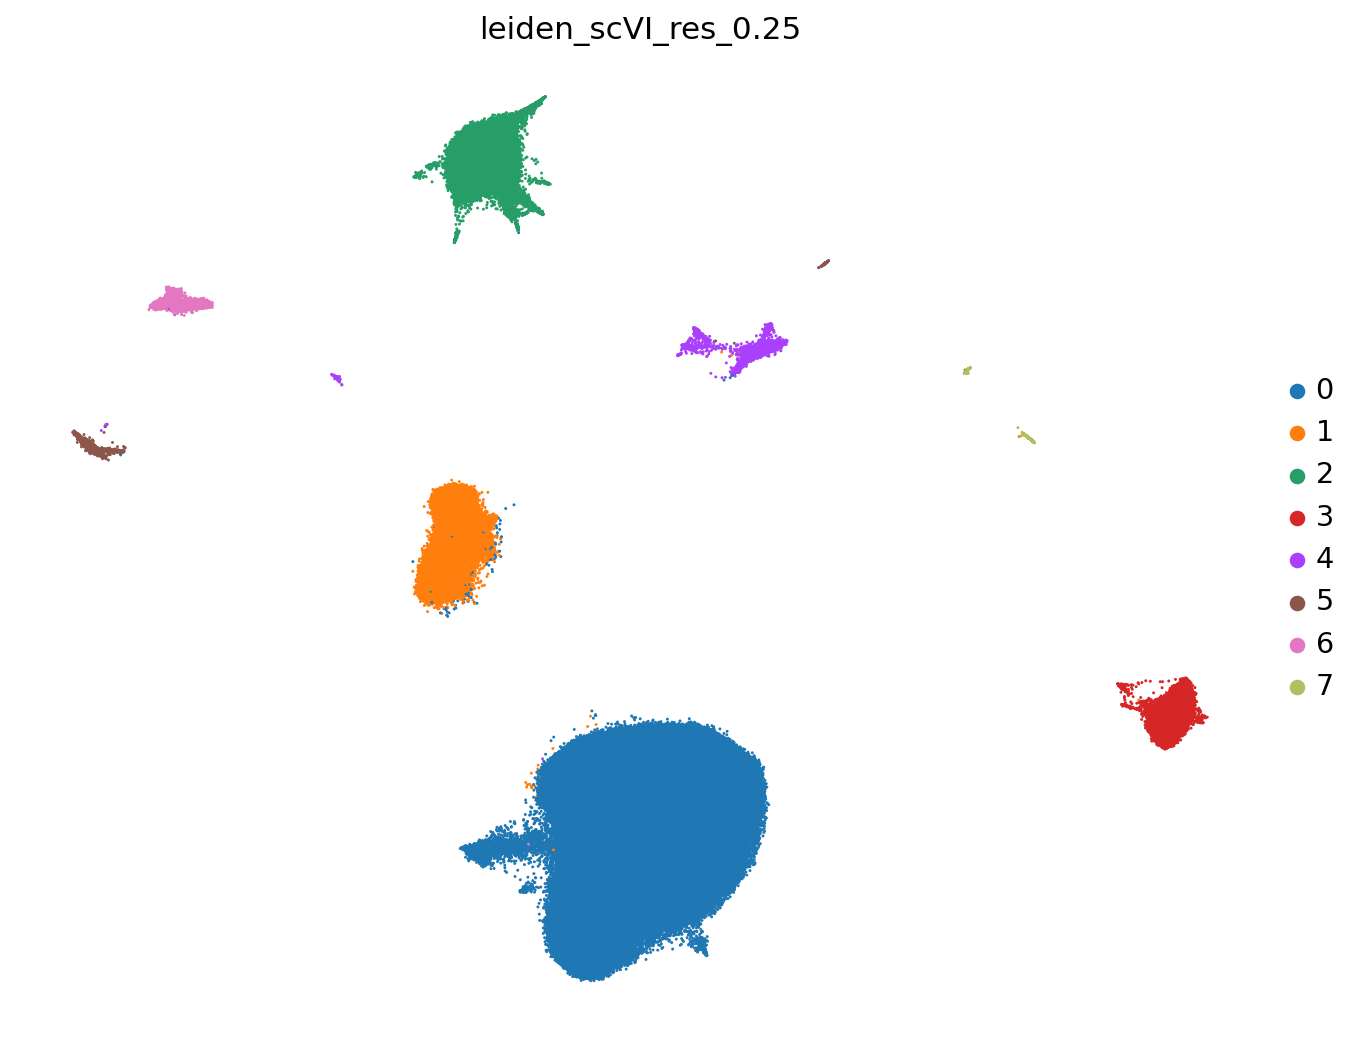

In [11]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_res_0.25"],
    frameon=False,
    size=7,
)

In [12]:
adata_macro = adata[(adata.obs['leiden_scVI_res_0.25'] == '4')
                     ]

In [13]:
print(adata_macro)

View of AnnData object with n_obs × n_vars = 6400 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25', 'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50'
    uns: 'OrigIdent_colors', 'doublet_info_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'leiden_scVI_res_0.25_colors'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p_counts'
    obsp: 'connectivities', 'distances'


Copy adata object to integrate clustering resultering with adata object that contains all genes

In [14]:
adata_macro_subset = adata_macro.copy()
adata_macro_subset_ALL_GENES = adata_macro_subset.copy()

## <br> 4. Determine top 2000 variable genes for clustering (subsets only top 2000 genes)

In [15]:
sc.pp.highly_variable_genes(
    adata_macro_subset,
    flavor="cell_ranger",
    n_top_genes=2000,
    #layer="counts",
    batch_key="OrigIdent",
    subset=True,
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/numba/core/dispatcher.py:289: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  entrypoints.init_all()


## <br> 5. Integration Cells with scVI

Expects raw counts as input

In [12]:
scvi.model.SCVI.setup_anndata(adata_macro_subset, 
                              layer="counts", 
                              batch_key="OrigIdent",
                              categorical_covariate_keys=["Dose", "Time"],
                              continuous_covariate_keys=["pct_counts_mt"],
                             )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Train Model

In [13]:
HV_Genes_model_macro = scvi.model.SCVI(adata_macro_subset, n_layers=2, n_latent=30)

In [14]:
HV_Genes_model_macro.train()

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/cholicog/miniconda3/envs/scvi-env/lib/pyth ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/cholicog/miniconda3/envs/scvi-env/lib/pyth ...
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [25:53<00:00,  2.11s/it, loss=802, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [25:53<00:00,  3.88s/it, loss=802, v_num=1]


Save Model

In [15]:
HV_Genes_model_macro.save("./Models/HV_Genes_Macro_Latent30/", save_anndata=True)

Load Model (if restarting)

In [16]:
#HV_Genes_model_macro = scvi.model.SCVI.load("./Models/HV_Genes_Macro_Latent30/")

INFO     File ./Models/HV_Genes_Macro_Latent30/model.pt already downloaded                                         


Save trained data to AnnData Objects

In [17]:
adata_macro_subset.obsm["X_scVI_train_macro"] = HV_Genes_model_macro.get_latent_representation()
adata_macro_subset_ALL_GENES.obsm["X_scVI_train_macro"] = HV_Genes_model_macro.get_latent_representation()

### <br> 5.1 Calculate neighbors and Conduct Leiden Clustering on 2000 highly variable gene adata

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


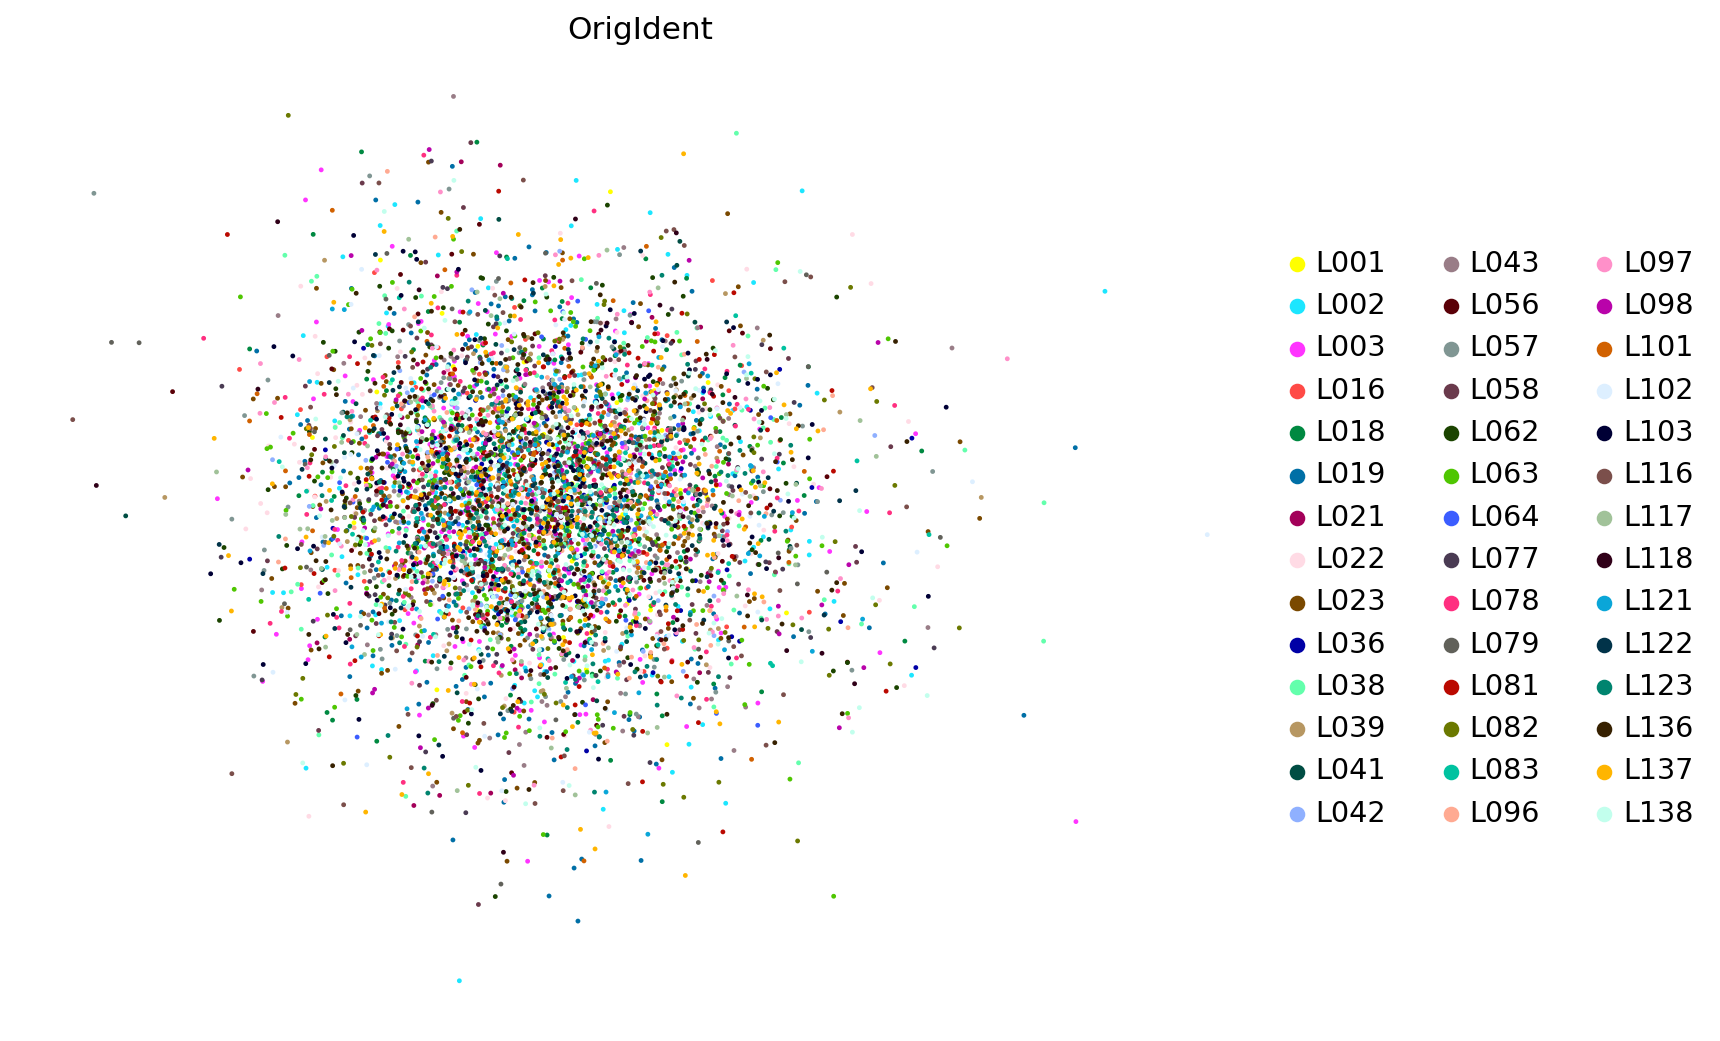

In [18]:
sc.pl.embedding(
    adata_macro_subset,
    basis="X_scVI_train_macro",
    color=["OrigIdent"],
    frameon=False,
    ncols=1,
)

In [19]:
sc.pp.neighbors(adata_macro_subset, 
                use_rep="X_scVI_train_macro", 
                random_state=5,
                method='umap'
               )

2023-09-21 15:00:06.077774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-21 15:00:06.077827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-21 15:00:06.077840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-21 15:00:08.820693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
sc.tl.umap(adata_macro_subset, 
           min_dist=0.1,
           random_state=5
          )

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


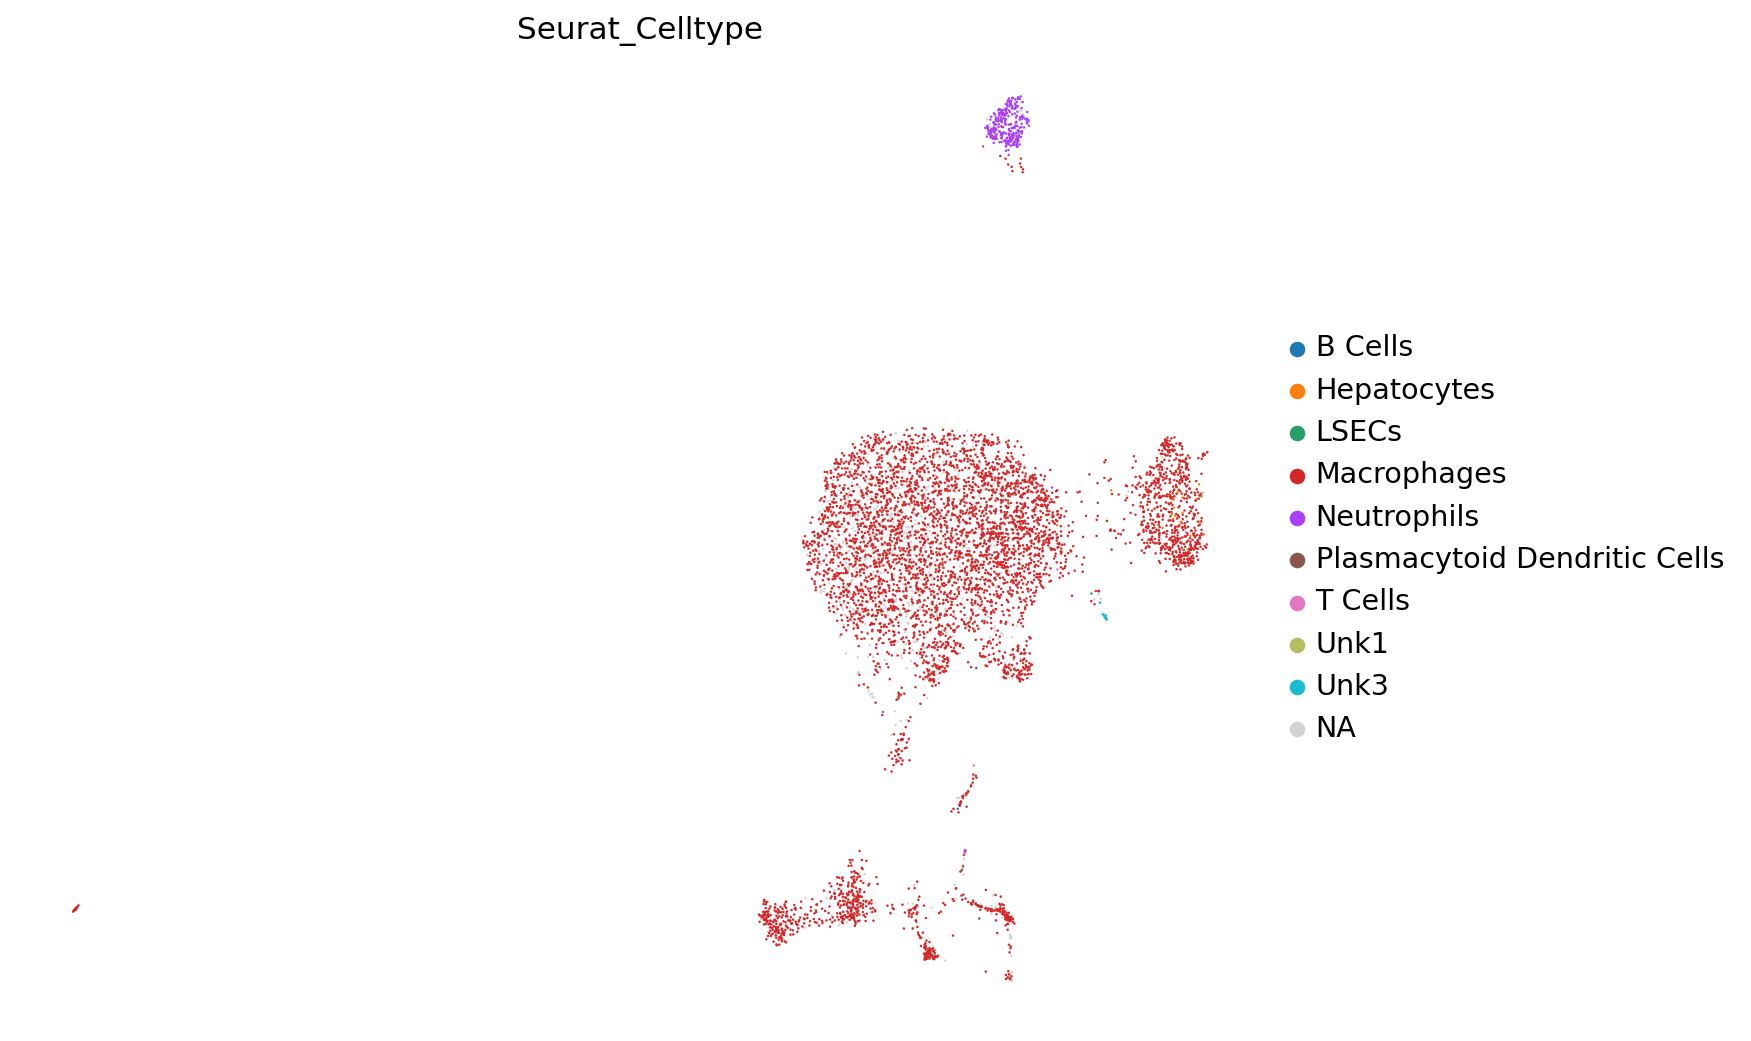

In [21]:
#latent 30
sc.pl.umap(
    adata_macro_subset,
    color=["Seurat_Celltype"],
    frameon=False,
    size=5,
    #save='_Clustering-Seurat_Celltype_immune.pdf'
)

In [22]:
sc.tl.leiden(adata_macro_subset, key_added="leiden_scVI_res_0.05_macro", resolution=0.05)
sc.tl.leiden(adata_macro_subset, key_added="leiden_scVI_res_0.1_macro", resolution=0.1)
sc.tl.leiden(adata_macro_subset, key_added="leiden_scVI_res_0.25_macro", resolution=0.25)
sc.tl.leiden(adata_macro_subset, key_added="leiden_scVI_res_0.5_macro", resolution=0.5)
sc.tl.leiden(adata_macro_subset, key_added="leiden_scVI_res_0.75_macro", resolution=0.75)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


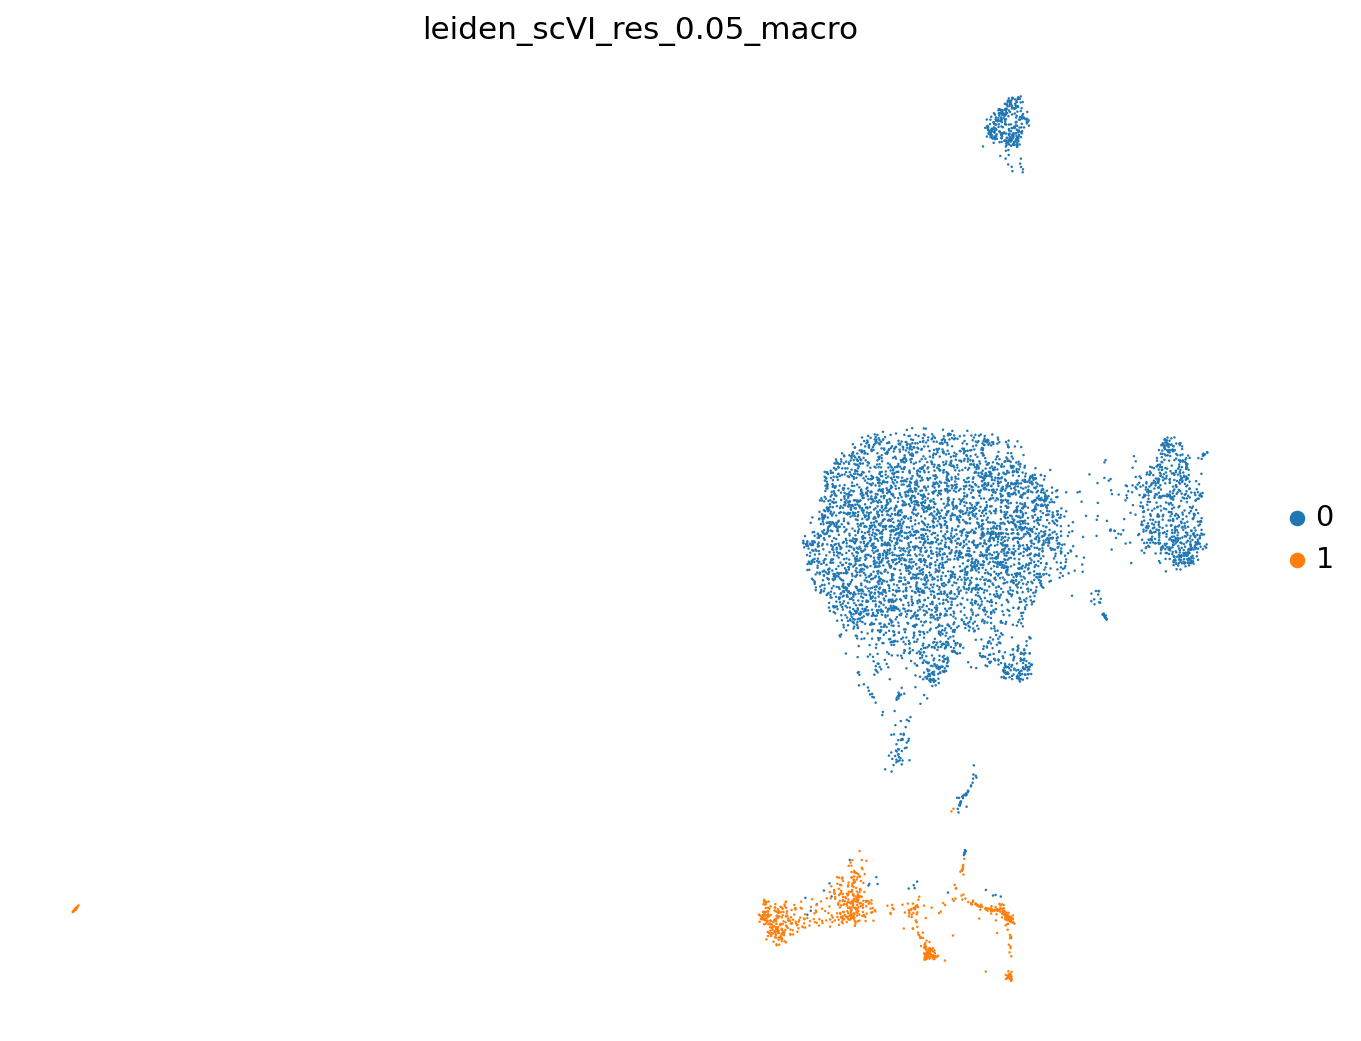

In [23]:
sc.pl.umap(
    adata_macro_subset,
    color=["leiden_scVI_res_0.05_macro"],
    frameon=False,
    size=5,
    #save='_Clustering-Res_0.05_immune.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


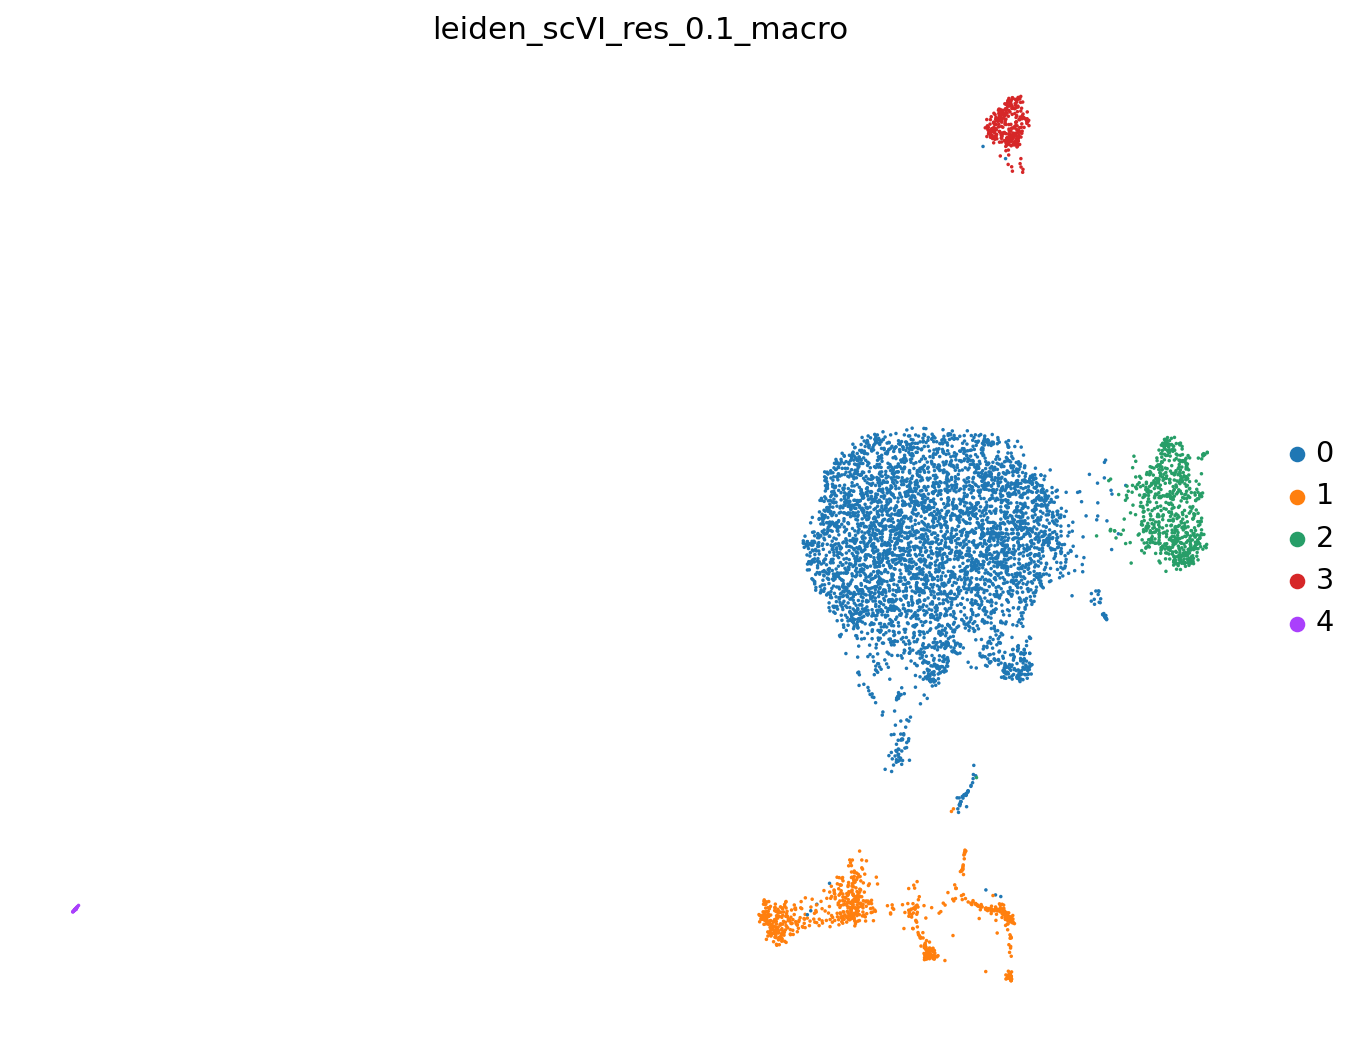

In [24]:
sc.pl.umap(
    adata_macro_subset,
    color=["leiden_scVI_res_0.1_macro"],
    frameon=False,
    size=10,
    #save='_Clustering-Res_0.1_immune.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


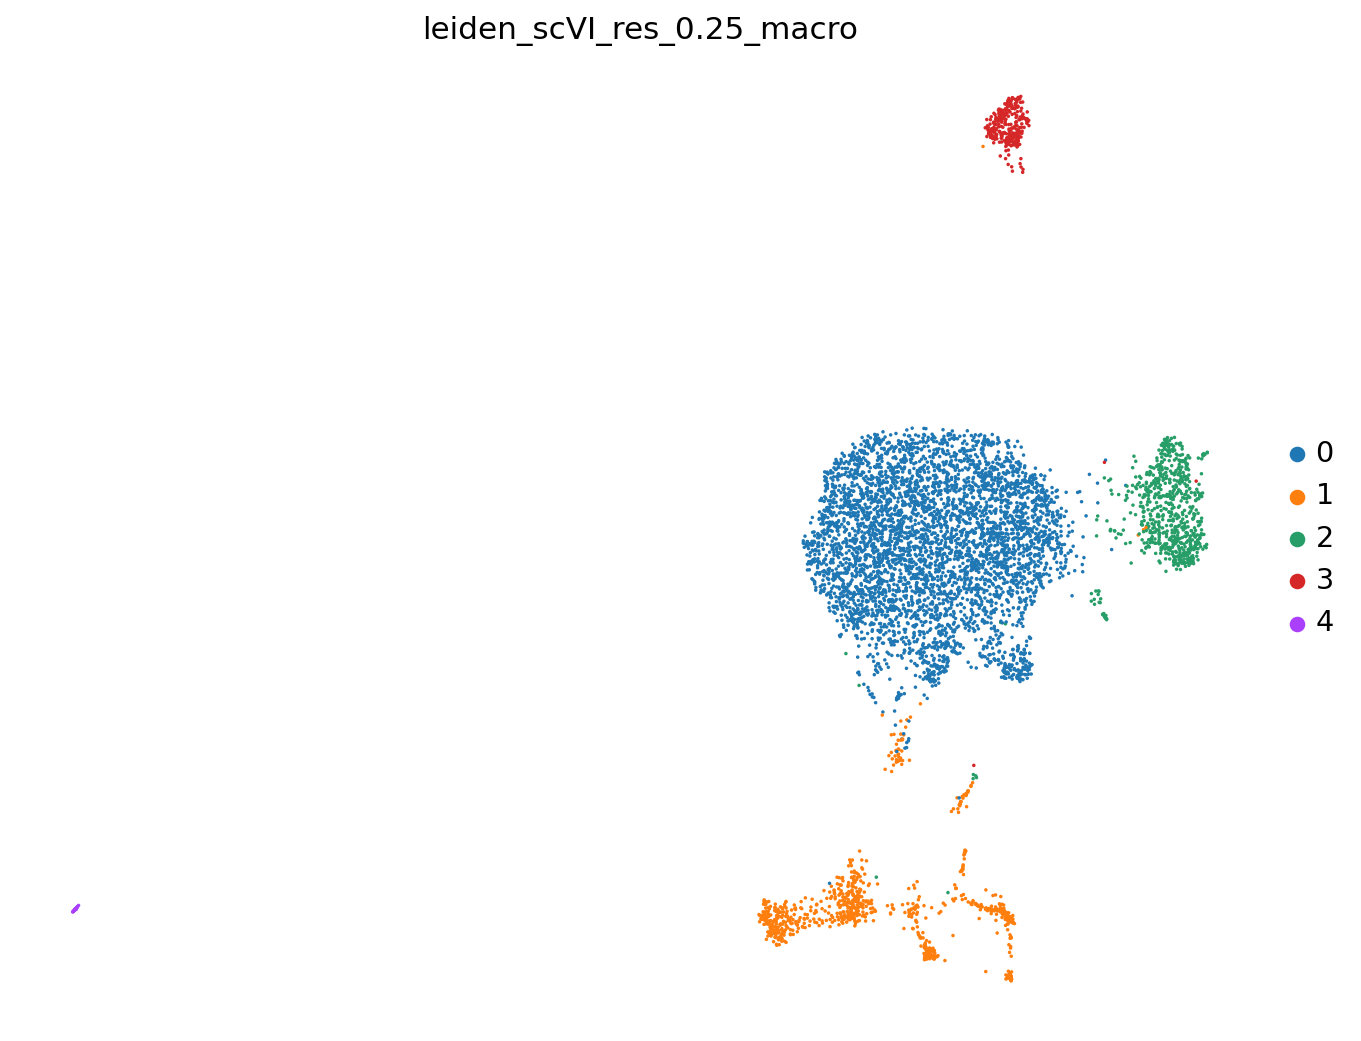

In [25]:
sc.pl.umap(
    adata_macro_subset,
    color=["leiden_scVI_res_0.25_macro"],
    frameon=False,
    size=10,
    #save='_Clustering-Res_0.25_immune.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


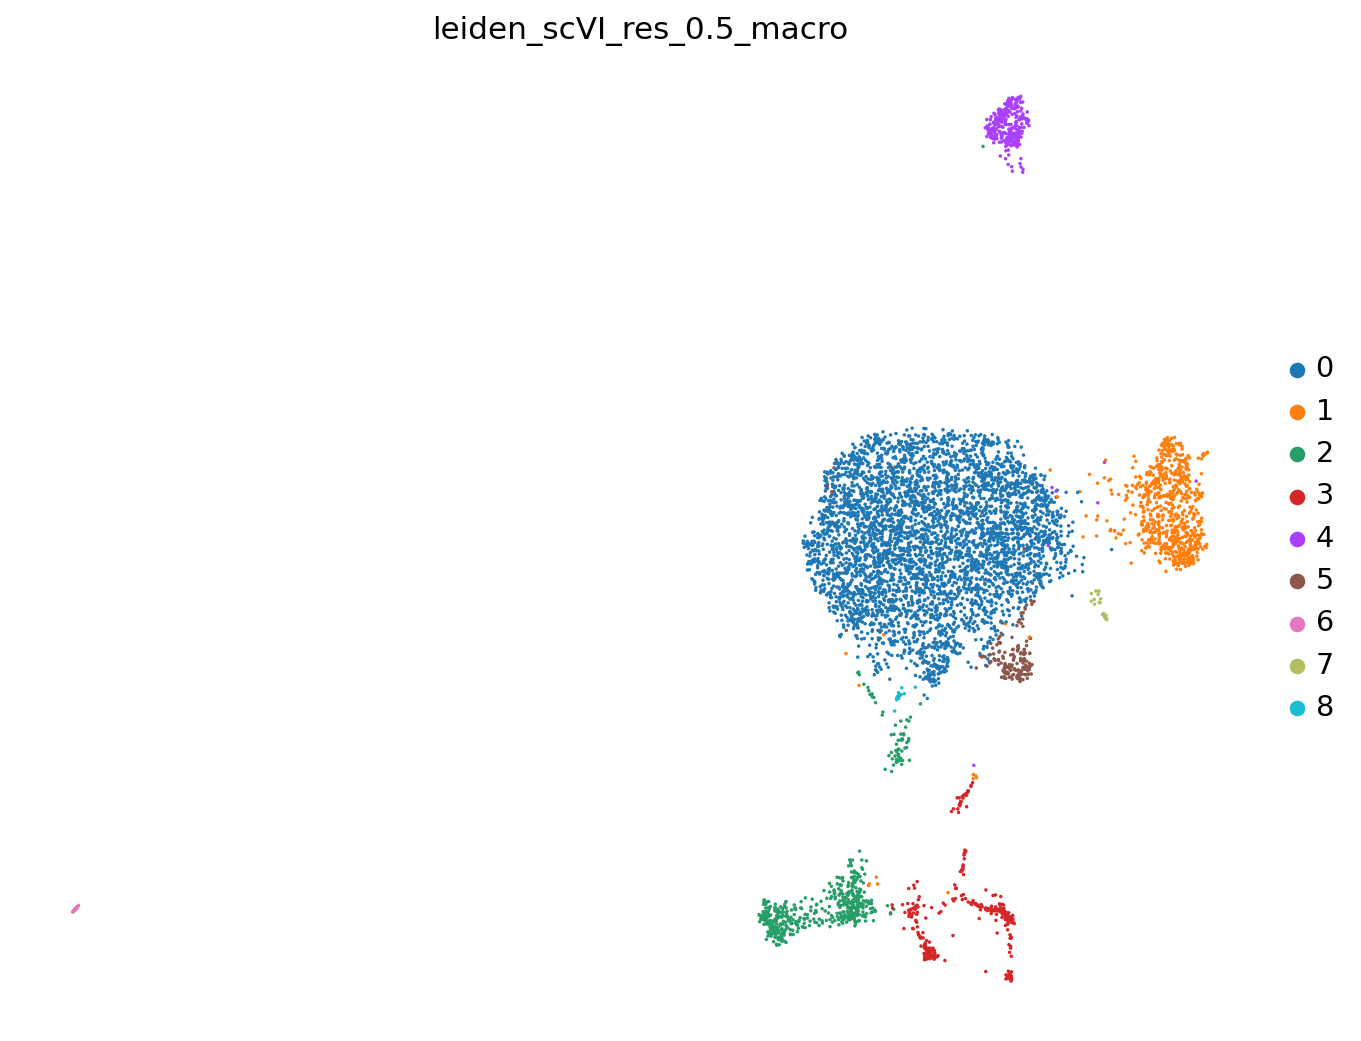

In [26]:
sc.pl.umap(
    adata_macro_subset,
    color=["leiden_scVI_res_0.5_macro"],
    frameon=False,
    size=10,
    #save='_Clustering-Res_0.5_immune.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


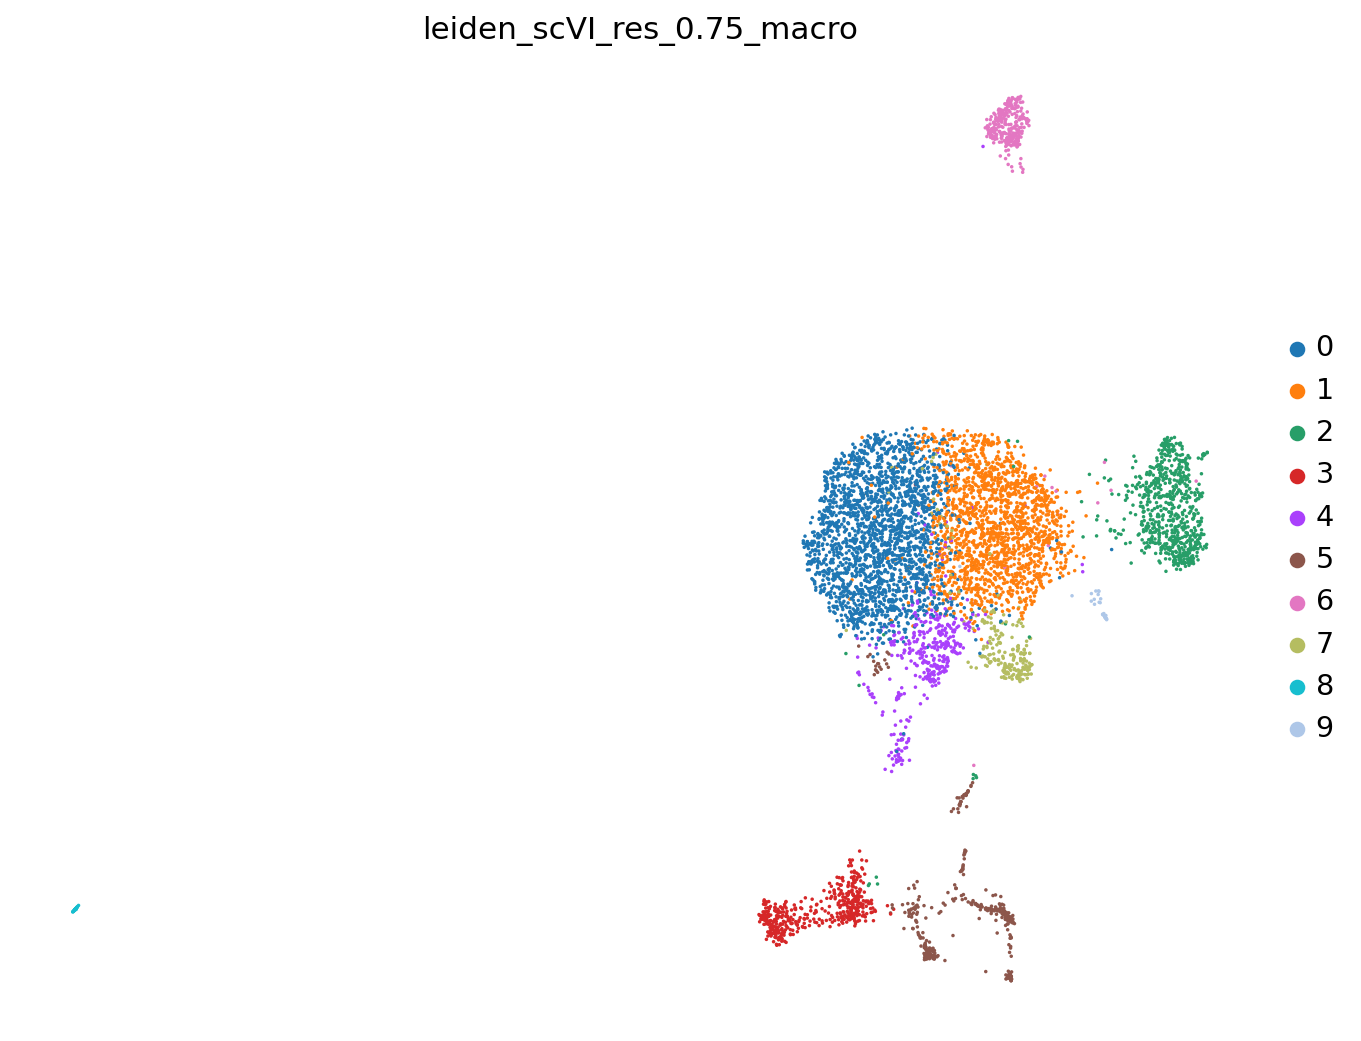

In [27]:
sc.pl.umap(
    adata_macro_subset,
    color=["leiden_scVI_res_0.75_macro"],
    frameon=False,
    size=10,
    #save='_Clustering-Res_0.75_immune.pdf'
)

Save AnnData Object

In [28]:
adata_macro_subset.write_h5ad('./Adata_Objects/01e_HVGenes_Clustered_Macro.h5ad',compression='gzip')

Load AnnData Object

In [ ]:
#adata_macro_subset = ad.read_h5ad('./Adata_Objects/01e_HVGenes_Clustered_Macro.h5ad')

### <br> 5.2 Calculate neighbors and Conduct Leiden Clustering on ALL GENES adata

In [29]:
sc.pp.neighbors(adata_macro_subset_ALL_GENES, 
                use_rep="X_scVI_train_macro", 
                random_state=5,
                method='umap'
               )

In [30]:
sc.tl.umap(adata_macro_subset_ALL_GENES, 
           min_dist=0.1,
           random_state=5
          )

In [31]:
sc.tl.leiden(adata_macro_subset_ALL_GENES, key_added="leiden_scVI_res_0.05_macro", resolution=0.05)
sc.tl.leiden(adata_macro_subset_ALL_GENES, key_added="leiden_scVI_res_0.1_macro", resolution=0.1)
sc.tl.leiden(adata_macro_subset_ALL_GENES, key_added="leiden_scVI_res_0.25_macro", resolution=0.25)
sc.tl.leiden(adata_macro_subset_ALL_GENES, key_added="leiden_scVI_res_0.5_macro", resolution=0.5)
sc.tl.leiden(adata_macro_subset_ALL_GENES, key_added="leiden_scVI_res_0.75_macro", resolution=0.75)

Save AnnData Object

In [32]:
adata_macro_subset_ALL_GENES.write_h5ad('./Adata_Objects/01e_AllGenes_Clustered_Macro.h5ad',compression='gzip')


Load AnnData Object

In [5]:
#adata_macro_subset_ALL_GENES = ad.read_h5ad('./Adata_Objects/01e_AllGenes_Clustered_Macro.h5ad')

# <br> 6. Rank Genes Wilcoxon (One Celltype vs. Rest) 

In [33]:
adata_macro_subset_ALL_GENES

AnnData object with n_obs × n_vars = 6400 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25', 'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50', 'leiden_scVI_res_0.05_macro', 'leiden_scVI_res_0.1_macro', 'leiden_scVI_res_0.25_macro', 'leiden_scVI_res_0.5_macro', 'leiden_scVI_res_0.75_macro'
    uns: 'OrigIdent_colors', 'doublet_info_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'leiden_scVI_res_0.25_colors'
    obsm: 'X_scVI', 'X_umap', 'X_scVI_train_macro'
    layers: 'counts', 'log1p_counts'
    obsp: 'connectivities', 'distances'

In [34]:
sc.pp.normalize_total(adata_macro_subset_ALL_GENES, target_sum=1e4)
sc.pp.log1p(adata_macro_subset_ALL_GENES)

In [35]:
sc.tl.rank_genes_groups(adata_macro_subset_ALL_GENES, 
                        groupby='leiden_scVI_res_0.1_macro', 
                        method='wilcoxon', 
                        key_added = "leiden_scVI_res_0.1_macro_wilcoxon"
                       )

Save AnnData Object

In [36]:
adata_macro_subset_ALL_GENES.write_h5ad('./Adata_Objects/01e_AllGenes_Clustered_Macro.h5ad',compression='gzip')


Load AnnData Object

In [ ]:
#adata_macro_subset_ALL_GENES = ad.read_h5ad('./Adata_Objects/01e_AllGenes_Clustered_Macro.h5ad')

### <br> Example on how to view results

In [37]:
sc.get.rank_genes_groups_df(adata_macro_subset_ALL_GENES, group='0', key='leiden_scVI_res_0.1_macro_wilcoxon')[:10]

names     scores  logfoldchanges  pvals  pvals_adj
0    Ptprm  50.217724        3.940454    0.0        0.0
1    Itga9  48.697865        3.730777    0.0        0.0
2   Frmd4b  48.632946        3.115752    0.0        0.0
3    Tmcc3  45.907856        3.382140    0.0        0.0
4    Mertk  45.830563        3.199390    0.0        0.0
5   Clec4f  43.815235        3.505018    0.0        0.0
6   Tcf7l2  42.550575        2.248929    0.0        0.0
7    Wdfy3  41.096825        2.067980    0.0        0.0
8    Myo9a  39.543892        2.636281    0.0        0.0
9  Pitpnc1  39.448570        2.143004    0.0        0.0

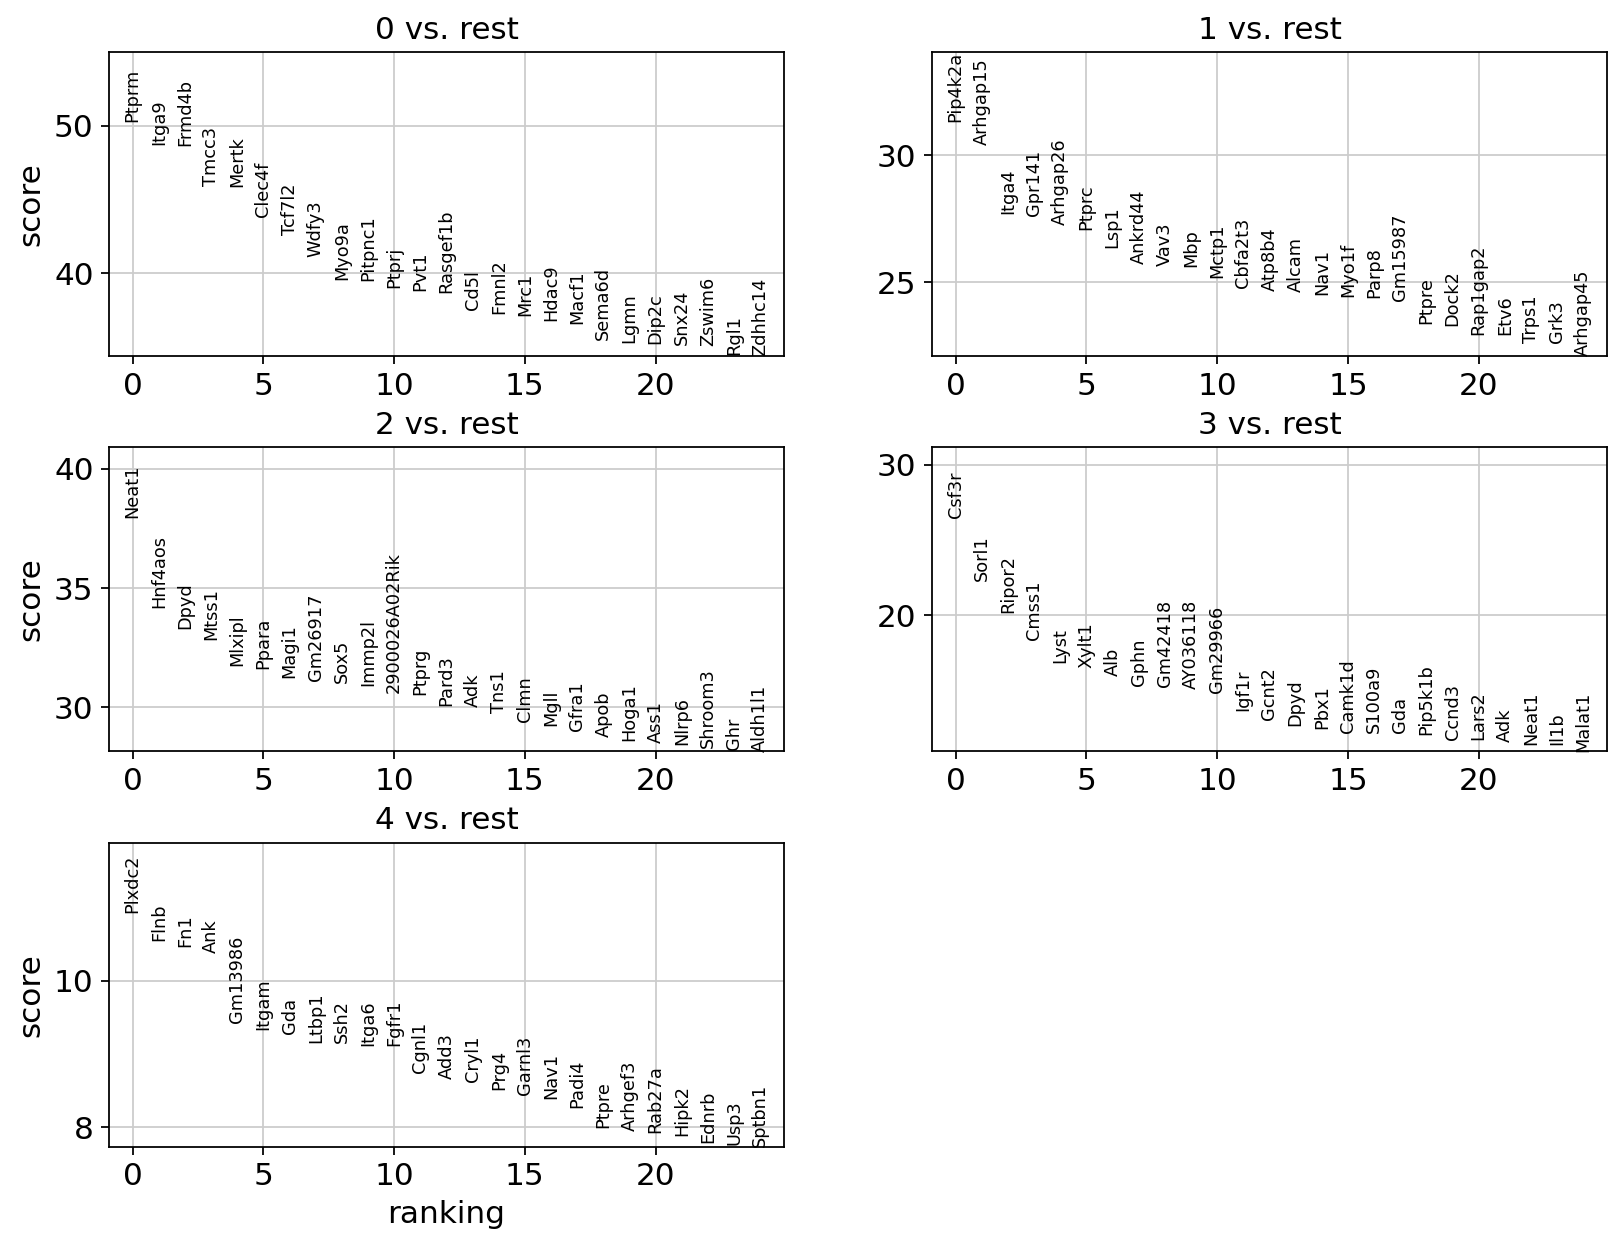

In [38]:
sc.set_figure_params(figsize=(6,3))

sc.pl.rank_genes_groups(adata_macro_subset_ALL_GENES, 
                        n_genes=25, 
                        sharey=False, 
                        key="leiden_scVI_res_0.1_macro_wilcoxon",
                        ncols=2,
                        #save='_Ranked_Genes_For_Each_Celltype.pdf'
                       )

# <br> 7. Determine the Celltype of Each Cluster

Use Seurat TC Label transfer as starting point

In [39]:
print(adata_macro_subset_ALL_GENES)

AnnData object with n_obs × n_vars = 6400 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25', 'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50', 'leiden_scVI_res_0.05_macro', 'leiden_scVI_res_0.1_macro', 'leiden_scVI_res_0.25_macro', 'leiden_scVI_res_0.5_macro', 'leiden_scVI_res_0.75_macro'
    uns: 'OrigIdent_colors', 'doublet_info_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'leiden_scVI_res_0.25_colors', 'leiden_scVI_res_0.1_macro_wilcoxon'
    obsm: 'X_scVI', 'X_umap', 'X_scVI_train_macro'
    layers: 'counts', 'log1p_counts'
    obsp: 'connectivities', 'distances'


/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


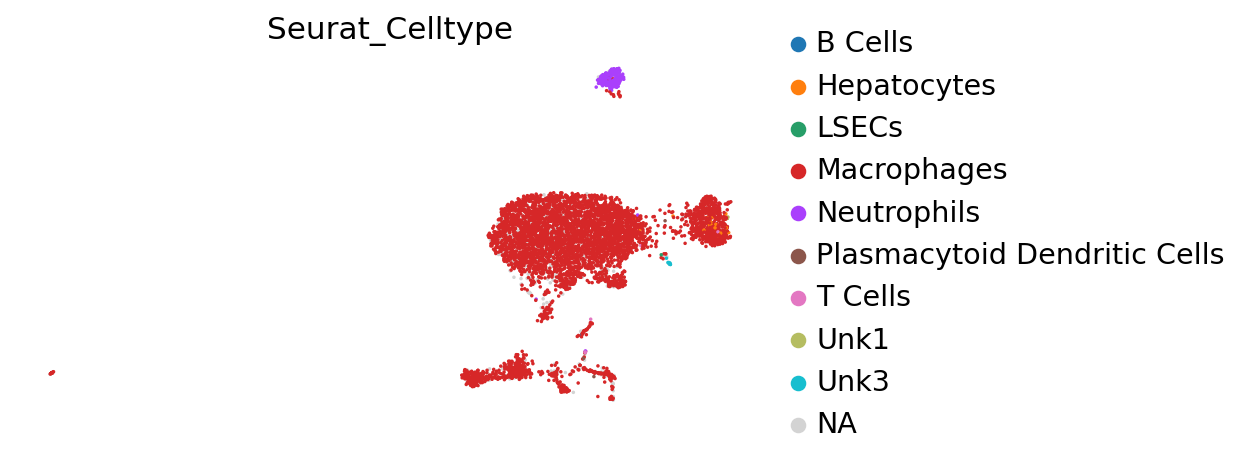

In [40]:
#latent30
sc.pl.umap(
    adata_macro_subset_ALL_GENES,
    color=["Seurat_Celltype"],
    frameon=False,
    size=10,
    #save='_Clustering--Latent_50--Res_1.25_immune.pdf'
)

The 0.1 and 0.25 resolutions seem like a good starting points.

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


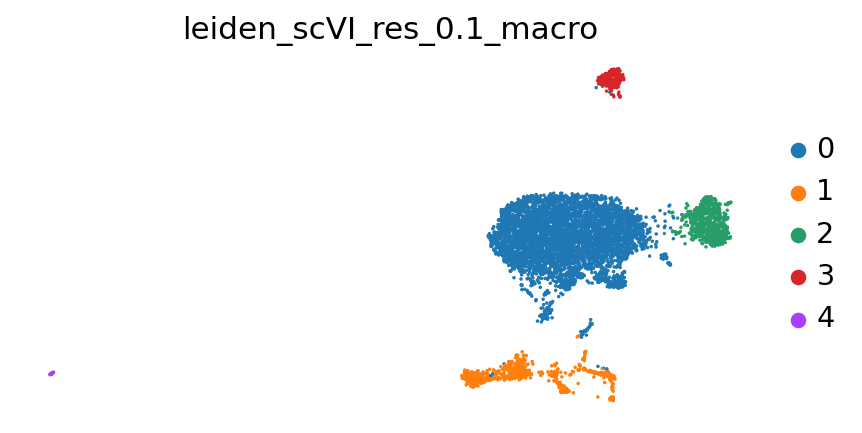

In [41]:
sc.pl.umap(
    adata_macro_subset_ALL_GENES,
    color=["leiden_scVI_res_0.1_macro"],
    frameon=False,
    size=10,
)


### <br> Cluster 0, 2, 4
KCs
- https://www.sciencedirect.com/science/article/pii/S0014480022000740#f0015 found Ptprm enriched in KC subpopulation
- Based on results from Guilliams et al (10.1016/j.cell.2021.12.018) Cd5l, Clec4f. Vsig4, Kcna2 suggests these clusters are KCs (See Jupyter Notebook 01c...)

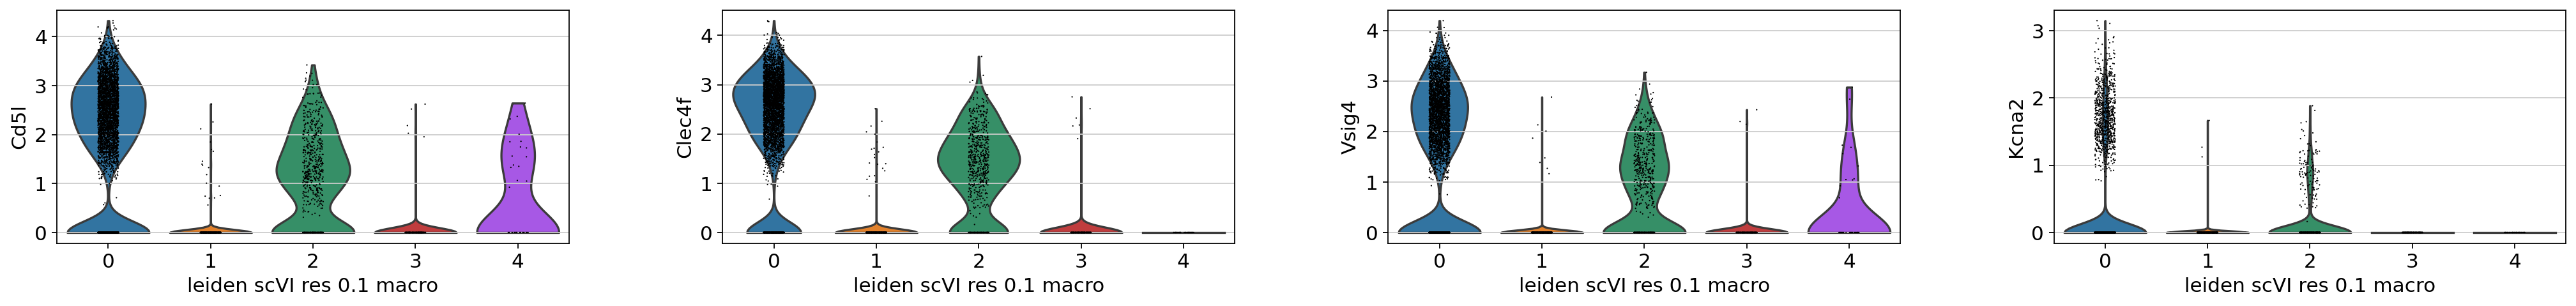

In [42]:
sc.pl.violin(
    adata_macro_subset_ALL_GENES,
    keys=['Cd5l','Clec4f','Vsig4','Kcna2'],
    groupby = 'leiden_scVI_res_0.1_macro',
)

### <br> Cluster 1
MDMs (Monocyte Derived Macrophages)
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6642742/ found Gpr141 enriched in infiltrating Macrophages
- Based on results from Guilliams et al (10.1016/j.cell.2021.12.018) Gpr141 suggests these clusters are Monocyte derivatives (See Jupyter Notebook 01c...)

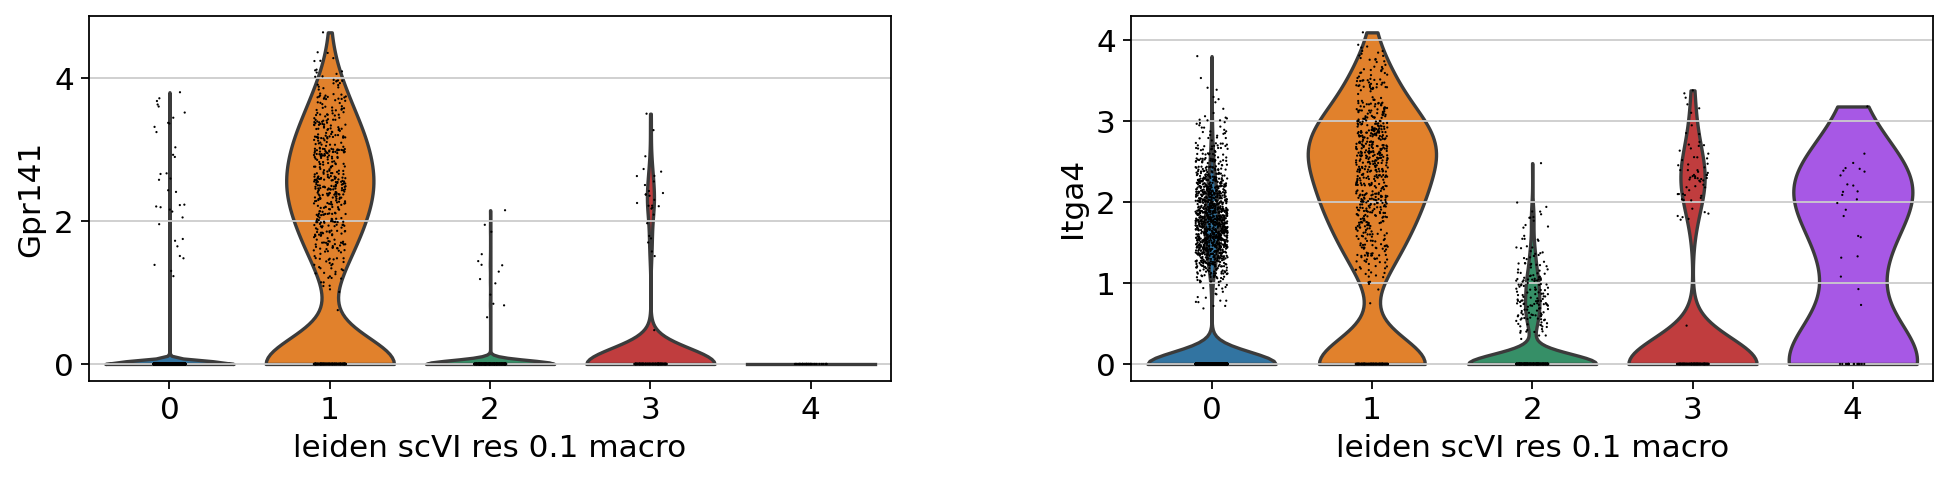

In [43]:
sc.pl.violin(
    adata_macro_subset_ALL_GENES,
    keys=['Gpr141', 'Itga4'],
    groupby = 'leiden_scVI_res_0.1_macro',
)

### <br> Cluster 3
Neutrophils
- Rance's Dose Repsonse suggests Csf3r is Neutrophils

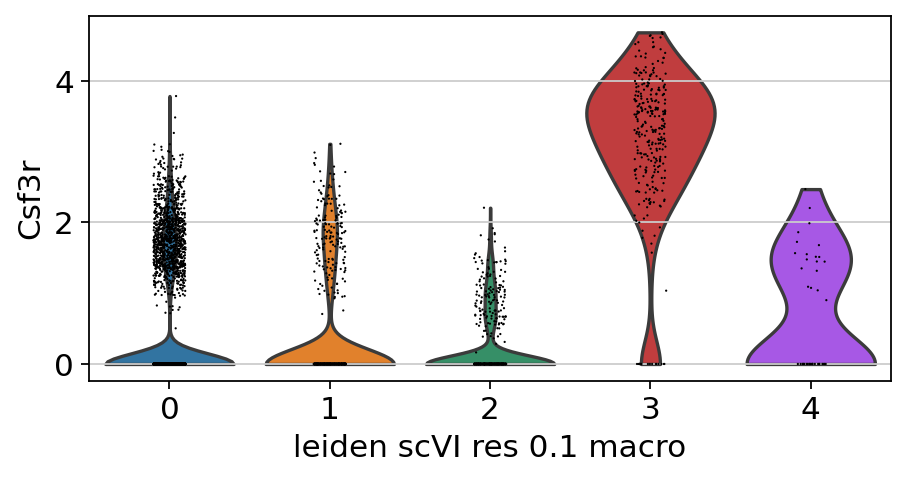

In [44]:
sc.pl.violin(
    adata_macro_subset_ALL_GENES,
    keys=['Csf3r'],
    groupby = 'leiden_scVI_res_0.1_macro',
)

# <br> 8. Label Cell Types in Adata Object:


In [45]:
bdata = adata_macro_subset_ALL_GENES.copy()

In [46]:
bdata.obs['Celltype'] = "Null"
bdata.obs['Cell_Subtype'] = "Null"

In [47]:
bdata.obs['Celltype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '0', "Macrophages", bdata.obs['Celltype'])
bdata.obs['Celltype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '1', "Macrophages", bdata.obs['Celltype'])
bdata.obs['Celltype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '2', "Macrophages", bdata.obs['Celltype'])
bdata.obs['Celltype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '3', "Macrophages", bdata.obs['Celltype'])
bdata.obs['Celltype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '4', "Macrophages", bdata.obs['Celltype'])


bdata.obs['Cell_Subtype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '0', "KCs", bdata.obs['Cell_Subtype'])
bdata.obs['Cell_Subtype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '1', "MDMs", bdata.obs['Cell_Subtype'])
bdata.obs['Cell_Subtype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '2', "KCs", bdata.obs['Cell_Subtype'])
bdata.obs['Cell_Subtype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '3', "Neutrophils", bdata.obs['Cell_Subtype'])
bdata.obs['Cell_Subtype'] = np.where(bdata.obs['leiden_scVI_res_0.1_macro'] == '4', "KCs", bdata.obs['Cell_Subtype'])


/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


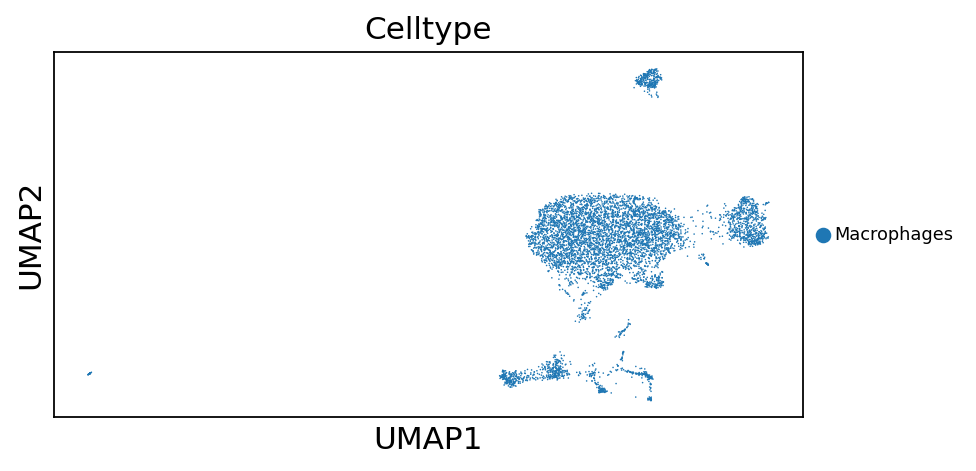

In [48]:
sc.pl.umap(
    bdata,
    color=["Celltype"],
    #legend_loc="on data",
    legend_fontsize=8,
    legend_fontweight='normal',
    frameon=True,
    size=2,
    #palette = sns.color_palette("hls", 10),
    #save='Annotated_Cells_For_Publishing-TCDDOnly.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


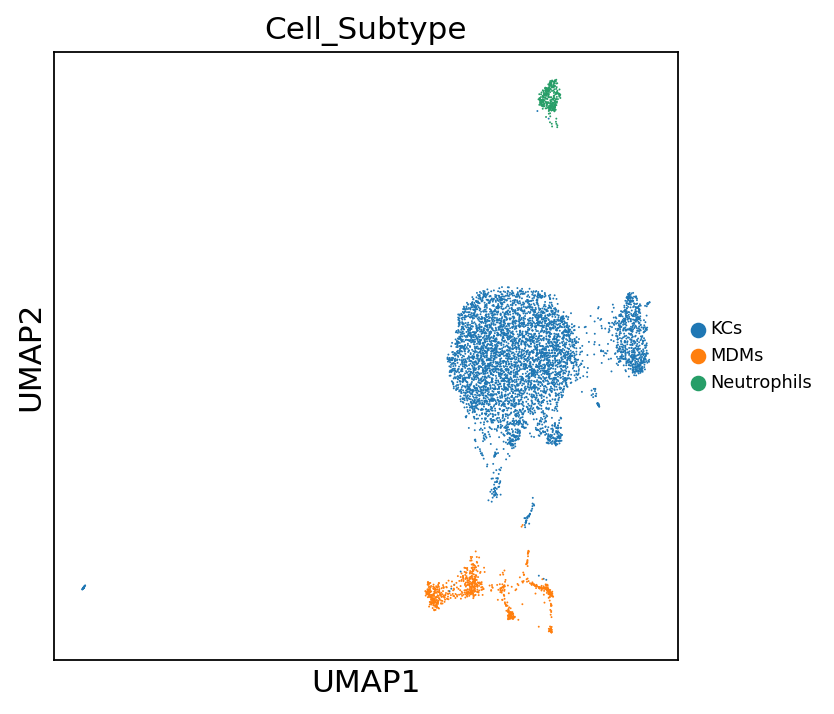

In [49]:
sc.set_figure_params(figsize=(5,5))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
pd.options.display.max_colwidth = 200

sc.pl.umap(
    bdata,
    color=["Cell_Subtype"],
    #legend_loc="on data",
    legend_fontsize=8,
    legend_fontweight='normal',
    frameon=True,
    size=3,
    #palette = sns.color_palette("hls", 10),
    #save='Annotated_EC_Subcelltypes_For_Publishing.pdf'
)

In [50]:
bdata.obs['Cell_Subtype'].value_counts()

KCs            5314
MDMs            790
Neutrophils     296
Name: Cell_Subtype, dtype: int64

Save AnnData Object

In [51]:
bdata.write_h5ad('./Adata_Objects/01e_AllGenes_Clustered_Macro_with_Neutrophils.h5ad',compression='gzip')


Load AnnData Object

In [3]:
#bdata = ad.read_h5ad('./Adata_Objects/01e_AllGenes_Clustered_Macro.h5ad')

# <br> 9. Subset Only Macrophages and Repeat Process

In [71]:
bdata_macro_subset = bdata[(bdata.obs['Cell_Subtype'] != 'Neutrophils')]

In [72]:
print(bdata)
print()
print(bdata_macro_subset)

AnnData object with n_obs × n_vars = 6400 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25', 'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50', 'leiden_scVI_res_0.05_macro', 'leiden_scVI_res_0.1_macro', 'leiden_scVI_res_0.25_macro', 'leiden_scVI_res_0.5_macro', 'leiden_scVI_res_0.75_macro', 'Celltype', 'Cell_Subtype'
    uns: 'OrigIdent_colors', 'doublet_info_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'leiden_scVI_res_0.25_colors', 'leiden_scVI_res_0.1_macro_wilcoxon', 'Seurat_Celltype_colors', 'leiden_scVI_res_0.1_macro_colors', 'Celltype_colors', 'Cell_Subtype_colors'
    obsm: 'X_scVI', 'X_umap', 'X_scVI_train_macro'
    layers: 'counts', 'log1p_counts'
    obsp: 'connectivities', 'distances'

View of Ann

In [73]:
bdata_macro_subset = bdata_macro_subset.copy()
bdata_macro_subset_ALL_GENES = bdata_macro_subset.copy()

In [74]:
bdata_macro_subset_ALL_GENES

AnnData object with n_obs × n_vars = 6104 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25', 'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50', 'leiden_scVI_res_0.05_macro', 'leiden_scVI_res_0.1_macro', 'leiden_scVI_res_0.25_macro', 'leiden_scVI_res_0.5_macro', 'leiden_scVI_res_0.75_macro', 'Celltype', 'Cell_Subtype'
    uns: 'OrigIdent_colors', 'doublet_info_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'leiden_scVI_res_0.25_colors', 'leiden_scVI_res_0.1_macro_wilcoxon', 'Seurat_Celltype_colors', 'leiden_scVI_res_0.1_macro_colors', 'Celltype_colors', 'Cell_Subtype_colors'
    obsm: 'X_scVI', 'X_umap', 'X_scVI_train_macro'
    layers: 'counts', 'log1p_counts'
    obsp: 'connectivities', 'distances'

Find 2000 most highly variable genes

In [55]:
sc.pp.highly_variable_genes(
    bdata_macro_subset,
    flavor="cell_ranger",
    n_top_genes=2000,
    #layer="counts",
    batch_key="OrigIdent",
    subset=True,
)

Integrate Cells with scVI

In [49]:
scvi.model.SCVI.setup_anndata(bdata_macro_subset, 
                              layer="counts", 
                              batch_key="OrigIdent",
                              categorical_covariate_keys=["Dose", "Time"],
                              continuous_covariate_keys=["pct_counts_mt"],
                             )

Train Model

In [50]:
HV_Genes_model_macro = scvi.model.SCVI(bdata_macro_subset, n_layers=2, n_latent=10)

In [51]:
HV_Genes_model_macro.train()

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/cholicog/miniconda3/envs/scvi-env/lib/pyth ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/cholicog/miniconda3/envs/scvi-env/lib/pyth ...
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:31<00:00,  1.77it/s, loss=765, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:31<00:00,  1.47it/s, loss=765, v_num=1]


Save Model

In [52]:
HV_Genes_model_macro.save("./Models/HV_Genes_Macro_with_Neutrophils_Removed_Latent10/", save_anndata=True)

Load Model (if restarting)

In [56]:
#HV_Genes_model_macro = scvi.model.SCVI.load("./Models/HV_Genes_Macro_with_Neutrophils_Removed_Latent30/")

INFO     File ./Models/HV_Genes_Macro_with_Neutrophils_Removed_Latent30/model.pt already downloaded                


Save trained data to AnnData Objects

In [75]:
bdata_macro_subset.obsm["X_scVI_train_macro"] = HV_Genes_model_macro.get_latent_representation()
bdata_macro_subset_ALL_GENES.obsm["X_scVI_train_macro"] = HV_Genes_model_macro.get_latent_representation()

In [76]:
sc.pp.neighbors(bdata_macro_subset_ALL_GENES, 
                use_rep="X_scVI_train_macro", 
                random_state=5,
                method='umap'
               )

In [77]:
sc.tl.umap(bdata_macro_subset_ALL_GENES, 
           min_dist=0.1,
           random_state=5
          )

In [80]:
bdata_macro_subset_ALL_GENES

AnnData object with n_obs × n_vars = 6400 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25', 'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50', 'leiden_scVI_res_0.05_macro', 'leiden_scVI_res_0.1_macro', 'leiden_scVI_res_0.25_macro', 'leiden_scVI_res_0.5_macro', 'leiden_scVI_res_0.75_macro'
    uns: 'OrigIdent_colors', 'doublet_info_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'leiden_scVI_res_0.25_colors', 'leiden_scVI_res_0.1_macro_wilcoxon', 'Seurat_Celltype_colors', 'leiden_scVI_res_0.1_macro_colors', 'Cell_Subtype_macro_wilcoxon'
    obsm: 'X_scVI', 'X_umap', 'X_scVI_train_macro'
    layers: 'counts', 'log1p_counts'
    obsp: 'connectivities', 'distances'

In [81]:
sc.pp.normalize_total(bdata_macro_subset_ALL_GENES, target_sum=1e4)
sc.pp.log1p(bdata_macro_subset_ALL_GENES)

In [82]:
sc.tl.rank_genes_groups(bdata_macro_subset_ALL_GENES, 
                        groupby='Cell_Subtype', 
                        method='wilcoxon', 
                        key_added = "Cell_Subtype_macro_wilcoxon"
                       )

Save AnnData Object

In [83]:
bdata_macro_subset_ALL_GENES.write_h5ad('./Adata_Objects/01e_AllGenes_Clustered_Macro_with_Neutrophils_Removed.h5ad',compression='gzip')


Load AnnData Object

In [3]:
#bdata_macro_subset_ALL_GENES = ad.read_h5ad('./Adata_Objects/01e_AllGenes_Clustered_Macro_with_Neutrophils_Removed.h5ad')

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


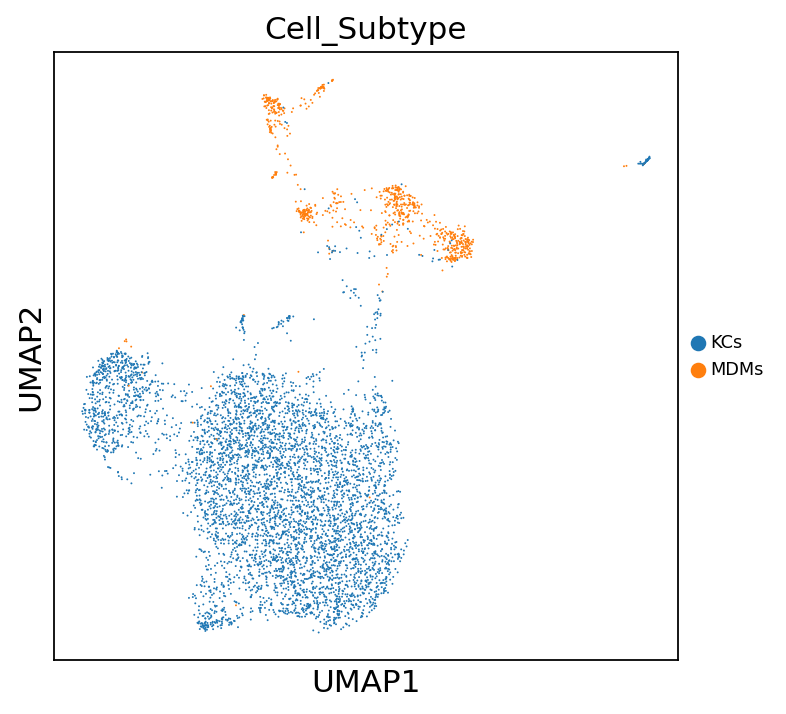

In [84]:
sc.set_figure_params(figsize=(5,5))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
pd.options.display.max_colwidth = 200

sc.pl.umap(
    bdata_macro_subset_ALL_GENES,
    color=["Cell_Subtype"],
    #legend_loc="on data",
    legend_fontsize=8,
    legend_fontweight='normal',
    frameon=True,
    size=3,
    #palette = sns.color_palette("hls", 10),
    save='Annotated_Macrophage_Subcelltypes_For_Publishing.pdf'
)

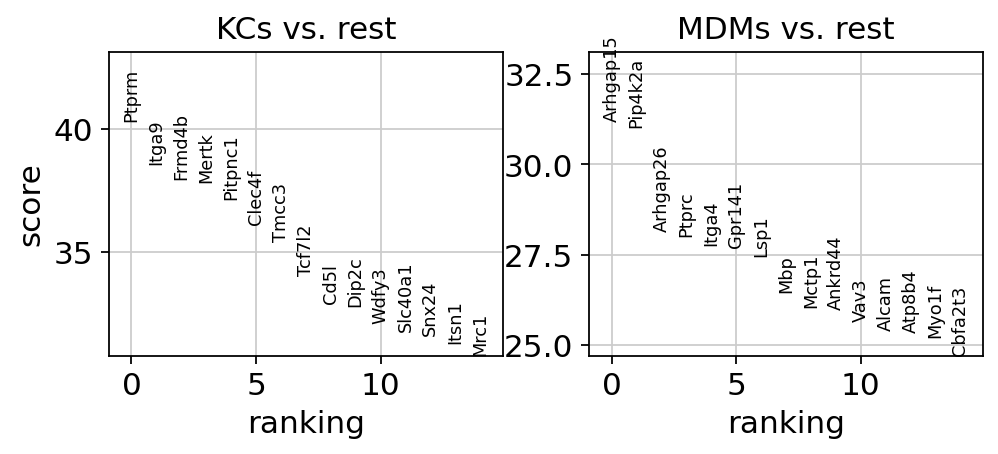

In [93]:
sc.set_figure_params(figsize=(3.5,2.5))

sc.pl.rank_genes_groups(bdata_macro_subset_ALL_GENES, 
                        n_genes=15, 
                        sharey=False, 
                        key="Cell_Subtype_macro_wilcoxon",
                        ncols=2,
                        save='_Ranked_Genes_For_Macrophages.pdf'
                       )

In [63]:
meta_data = bdata_macro_subset_ALL_GENES.obs[['OrigIdent','Dose','Time']].drop_duplicates(keep='first')
cell_data = bdata_macro_subset_ALL_GENES.obs[['OrigIdent','Cell_Subtype']]

# Group by "OrigIdent" and "Cell_Subtype" and count the occurrences
grouped = cell_data.groupby(["OrigIdent", "Cell_Subtype"]).size().reset_index(name="count")

# Pivot the table
pivot_table = pd.pivot_table(grouped, values='count', index='OrigIdent', columns='Cell_Subtype', fill_value=0)

# Display the pivot table
pivot_table

Cell_Subtype  KCs  MDMs
OrigIdent              
L001           56     3
L002          181    16
L003          198    16
L016           64     8
L018          138     9
L019          276    22
L021           43    11
L022          132    17
L023          262    23
L036           67     6
L038          181    29
L039          141     5
L041           89     6
L042           63     9
L043          154    11
L056          105     7
L057          123    21
L058          127    14
L062          194    11
L063          236    22
L064           40     6
L077           88    13
L078          155     3
L079           48    11
L081           94    60
L082          142    42
L083           58    13
L096           61    18
L097          122    17
L098           87    15
L101           60    44
L102          106    22
L103          171    32
L116          108    34
L117           87     9
L118           86    15
L121          116    21
L122           84    17
L123          246    24
L136          177    40
L137          192    41
L138          156    27

In [64]:
pivot_table.to_csv('./Cell(sub)type_Counts/01e_Macrophage_CellCounts_Split_by_Dose_and_Time.txt', sep='\t')
meta_data.to_csv('./Cell(sub)type_Counts/01e_Macrophage_MetaData_Split_by_Dose_and_Time.txt', sep='\t', index=None)

In [ ]:
#Tinkering

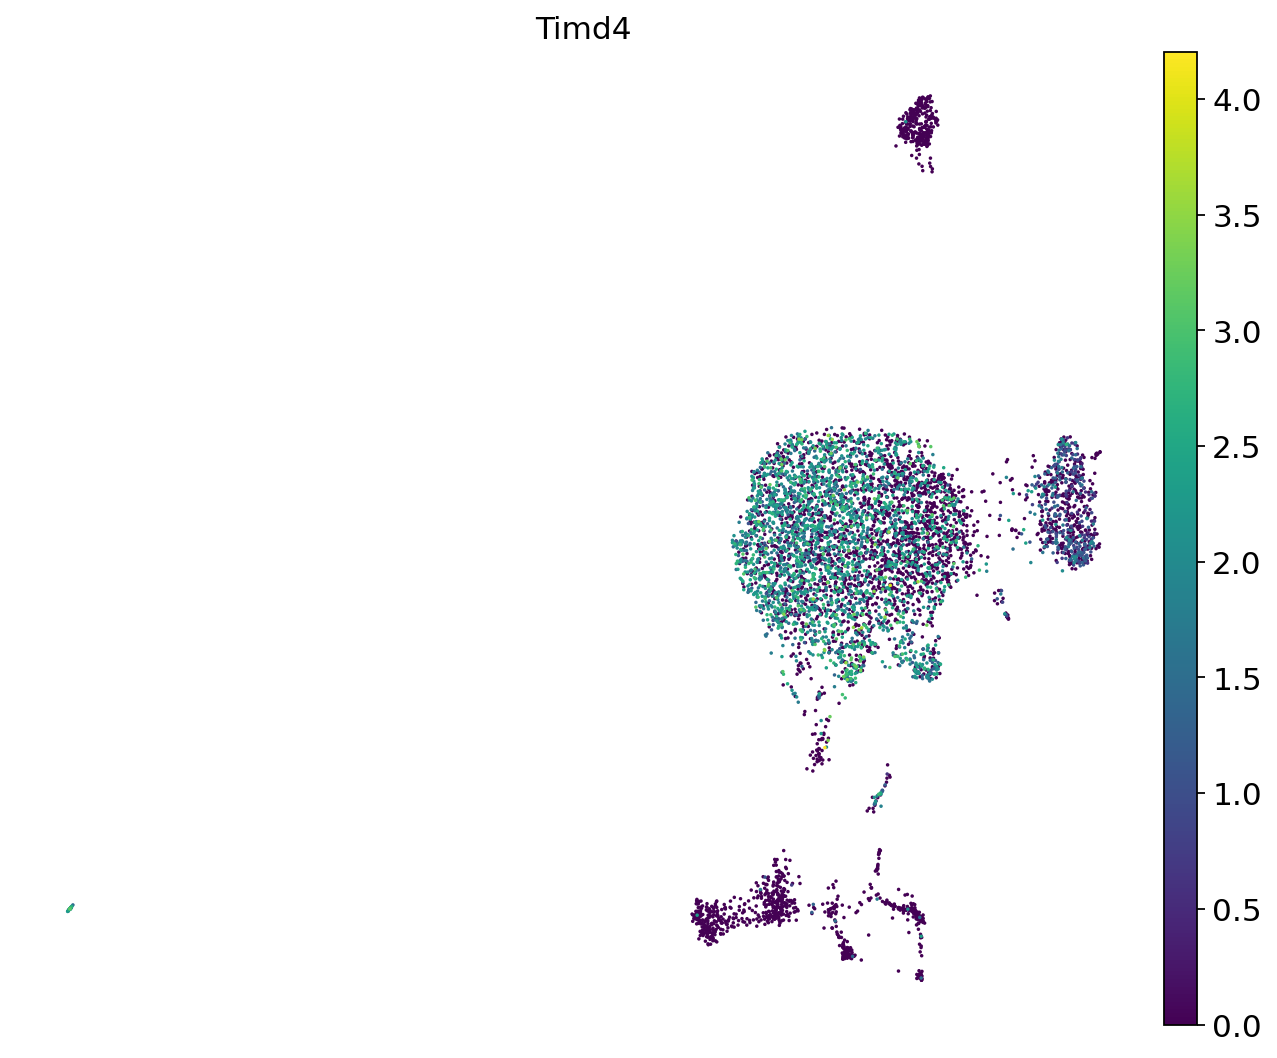

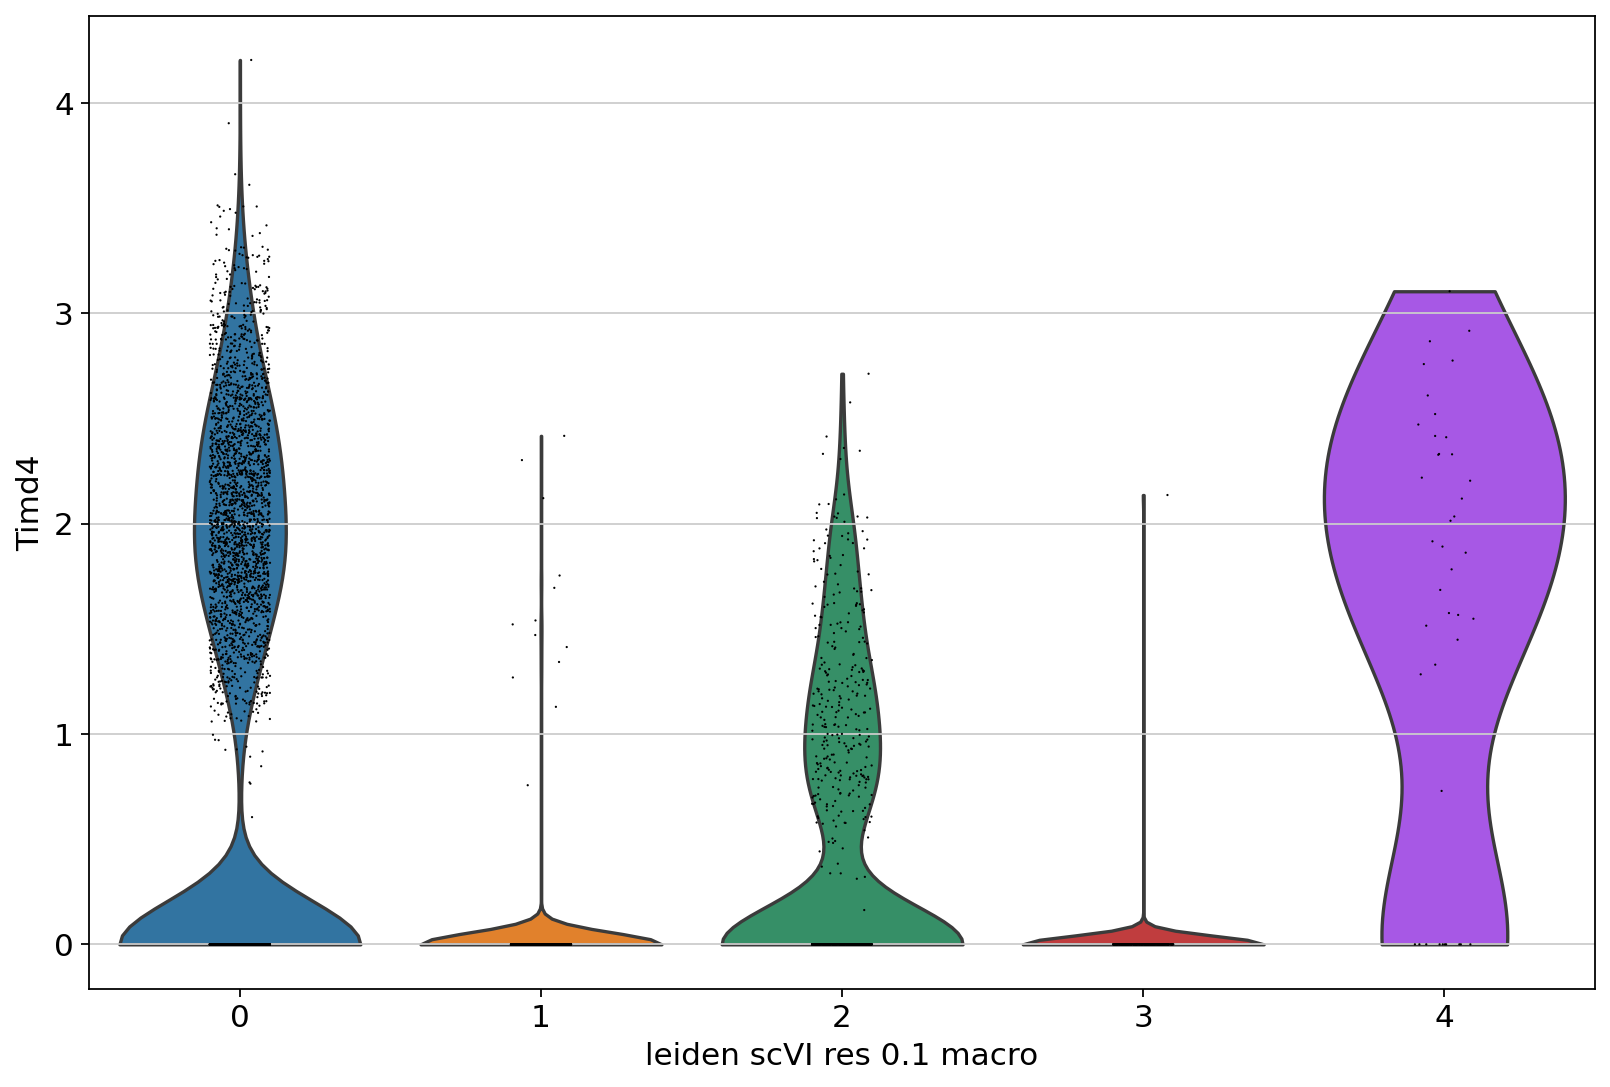

In [11]:
sc.pl.umap(
    bdata,
    color=["Timd4"],
    frameon=False,
    size=10,
)

sc.pl.violin(
    bdata,
    keys=['Timd4'],
    groupby = 'leiden_scVI_res_0.1_macro',
)


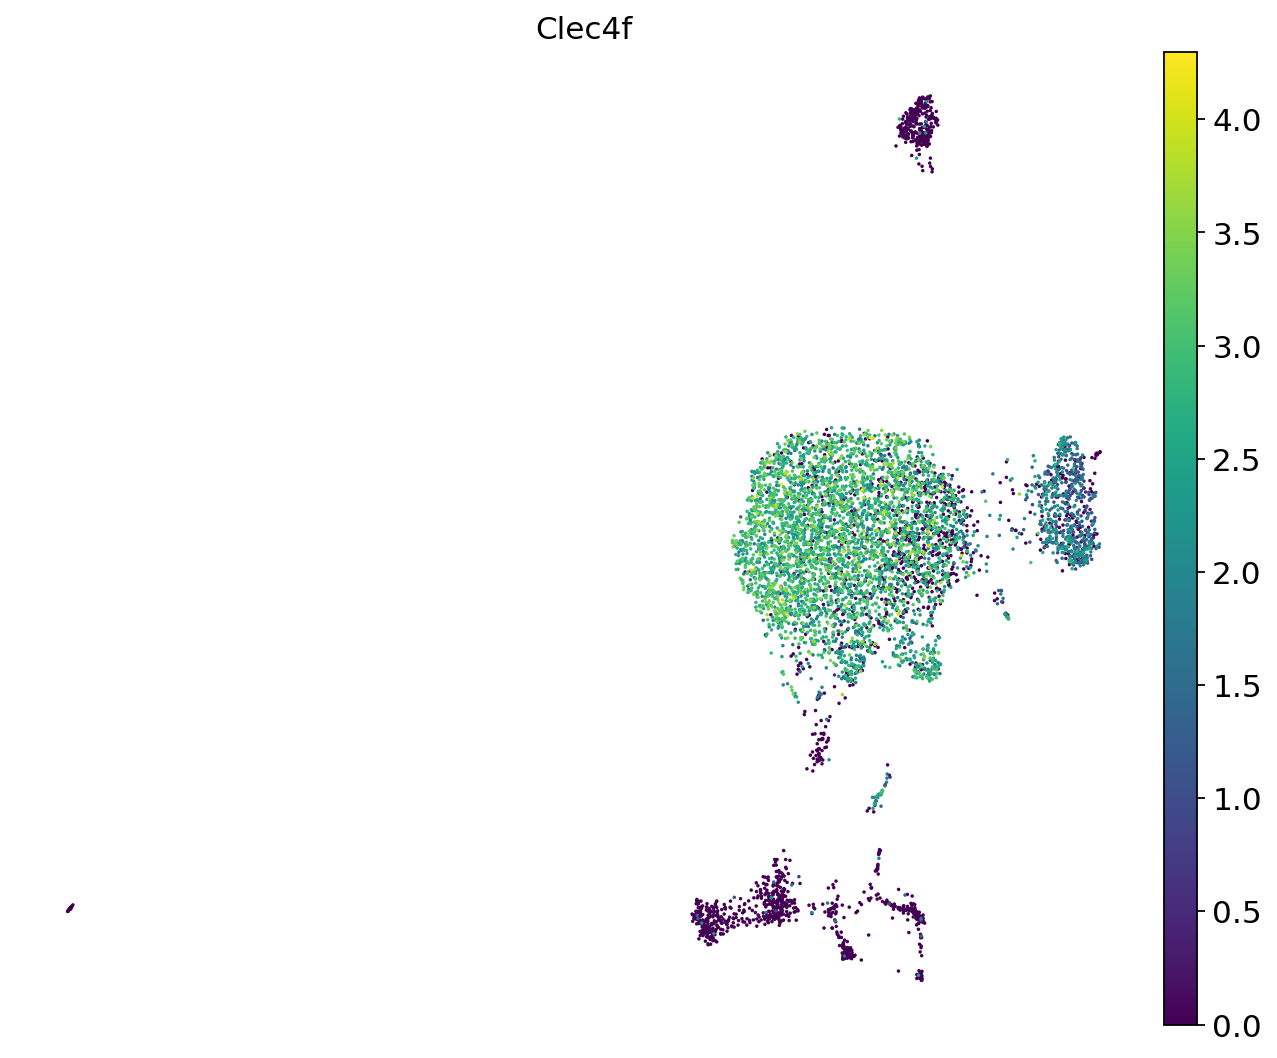

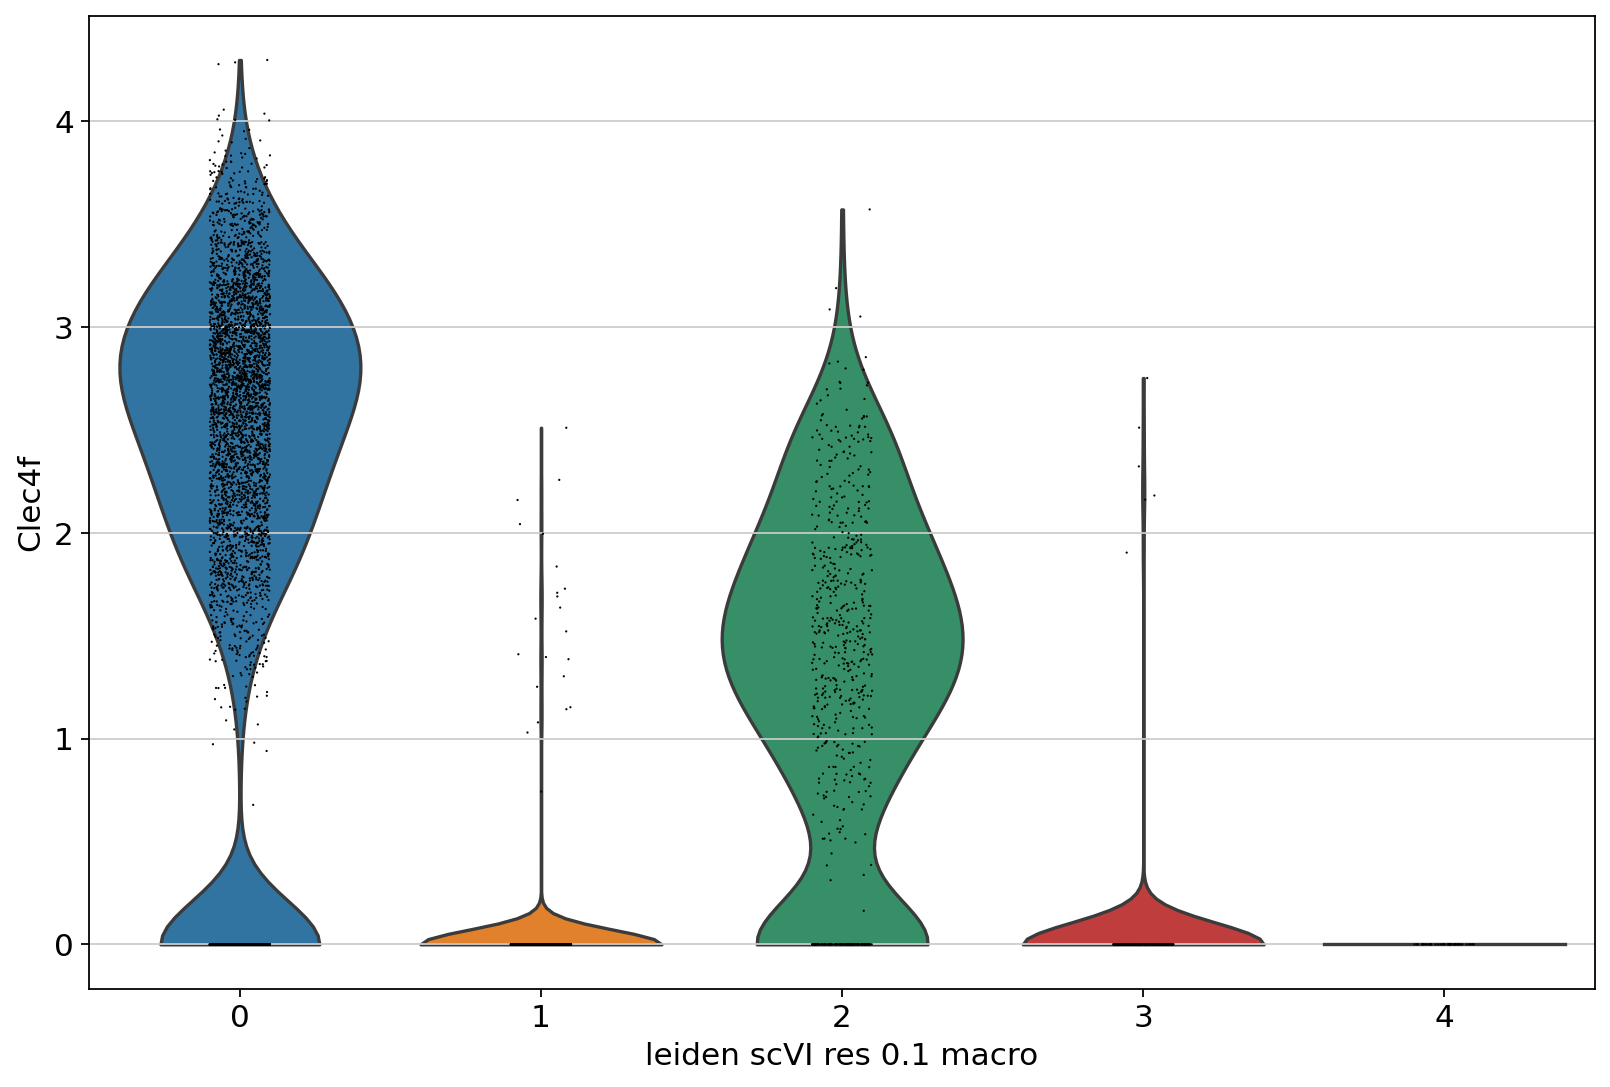

In [14]:
sc.pl.umap(
    bdata,
    color=["Clec4f"],
    frameon=False,
    size=10,
)

sc.pl.violin(
    bdata,
    keys=['Clec4f'],
    groupby = 'leiden_scVI_res_0.1_macro',
)


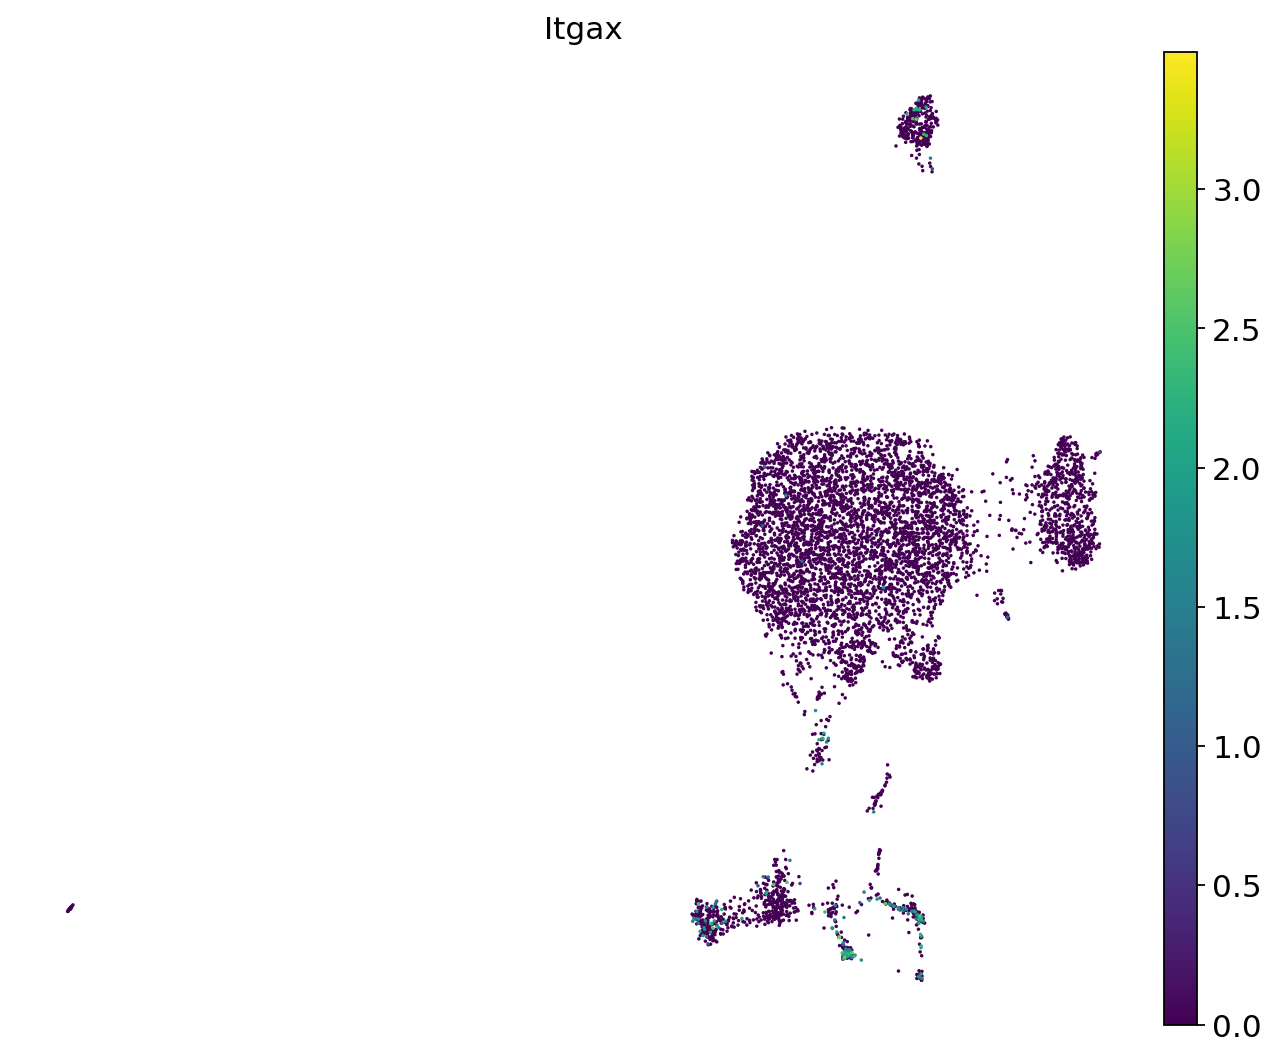

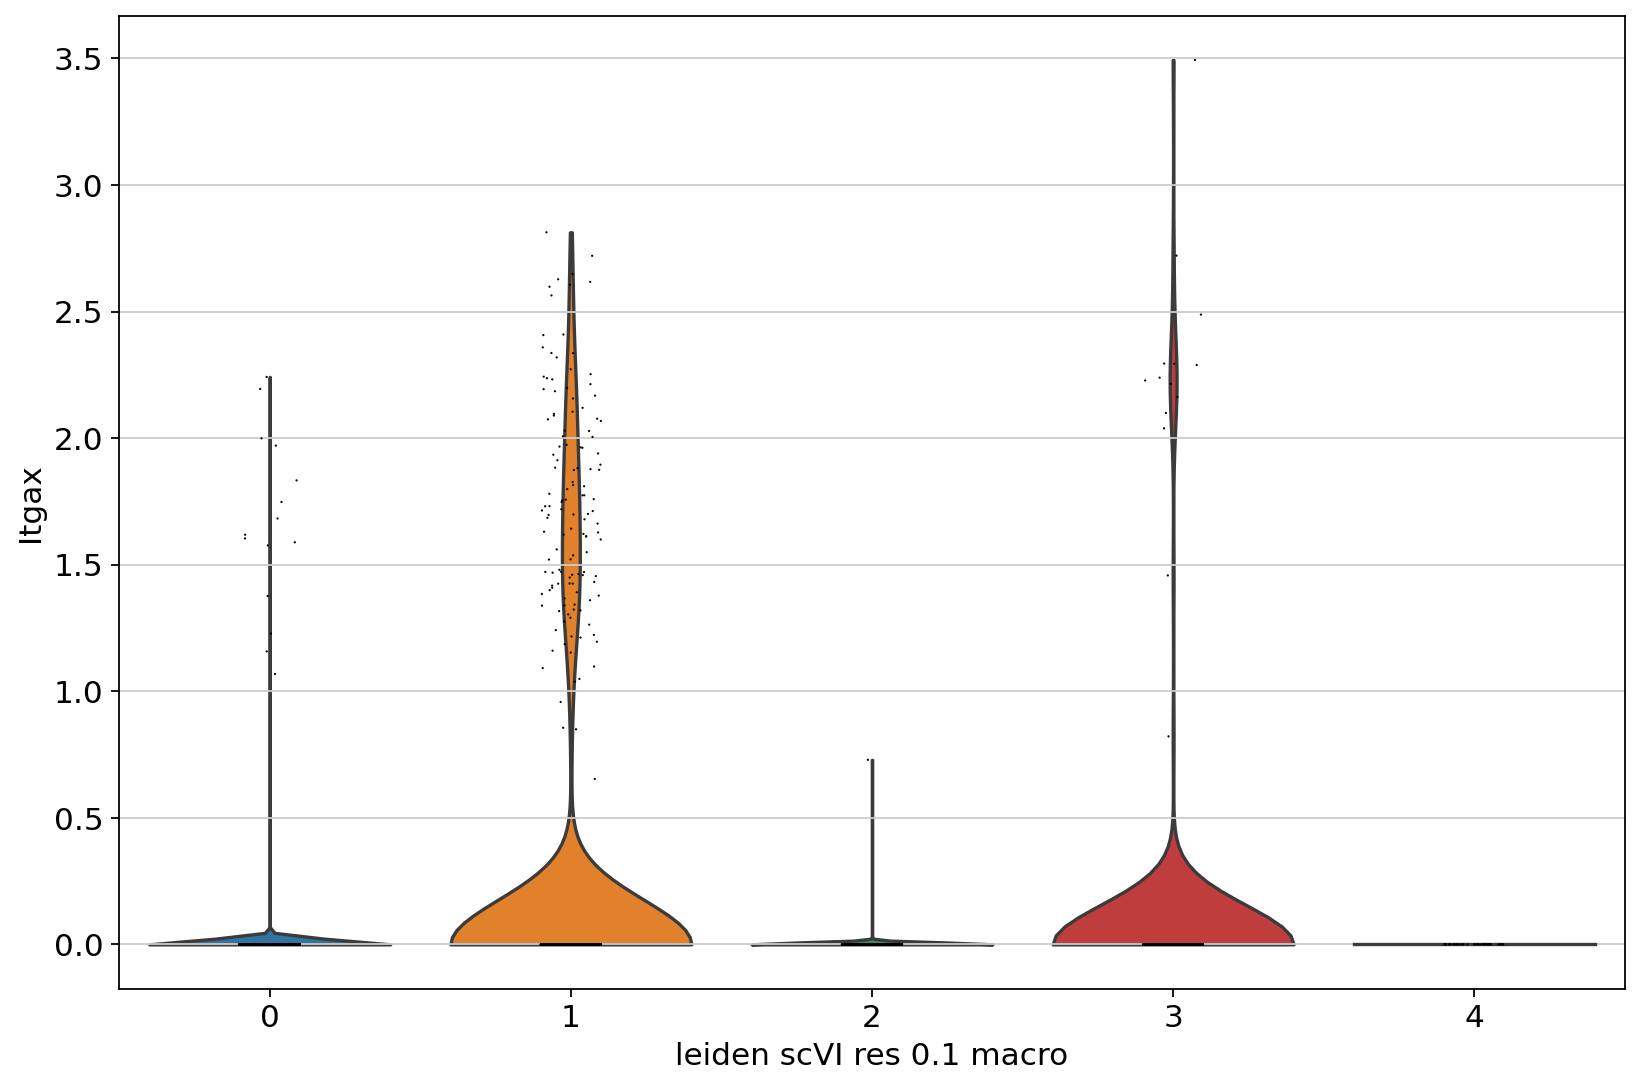

In [13]:
sc.pl.umap(
    bdata,
    color=["Itgax"],
    frameon=False,
    size=10,
)

sc.pl.violin(
    bdata,
    keys=['Itgax'],
    groupby = 'leiden_scVI_res_0.1_macro',
)